# Choose Cluster

In [1]:
cluster_input = 22

# Quick Links

<ol>
    <li><a href=#prep_main_scores>Prepare GkmExplain, ISM, and deltaSVM Scores</a></li>
    <li><a href=#prep_conf_scores>Prepare Magnitude and Prominence Scores</a></li>
    <li><a href=#prep_score_df>Prepare Score DataFrames</a></li>
    <li><a href=#plot_score_distrib>Plot Score Distributions</a></li>
    <li><a href=#calculate_pvals>Calculate P-Values</a></li>
    <li><a href=#visualize_high_conf>Visualize High Confidence SNPs</a></li>
    <li><a href=#prep_final_table>Prepare Final SNPs Table</a></li>
</ol>

## Imports

In [2]:
# Basic

import sys
import math
import random
import statistics
from decimal import Decimal

# Data / ML / Stats Libraries

import numpy as np
import pandas as pd
import scipy
from scipy.stats import *
pd.set_option('display.max_columns', None)

# Visualization

from matplotlib import pyplot as plt
from plotnine import *
sys.path.insert(0, '/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm')
from viz_preprocess import *
from viz_sequence import *
import warnings
warnings.filterwarnings('ignore')
plt.style.use('default')

## Addresses

In [3]:
cluster = str(cluster_input)
clust_to_celltype = {1: 'excitatory_neurons', 2: 'inhibitory_neurons', 3: 'excitatory_neurons',
                     4: 'excitatory_neurons', 5: 'nigral_neurons', 6: 'nigral_neurons', 7: 'unknown_neurons',
                     8: 'opcs', 9: 'opcs', 10: 'opcs', 11: 'inhibitory_neurons',12: 'inhibitory_neurons',
                     13: 'astrocytes', 14: 'astrocytes', 15: 'astrocytes', 16: 'astrocytes', 17: 'astrocytes',
                     18: 'doublets', 19: 'oligodendrocytes', 20: 'oligodendrocytes', 21: 'oligodendrocytes',
                     22: 'oligodendrocytes', 23: 'oligodendrocytes', 24: 'microglia'}
celltype = clust_to_celltype[cluster_input]
observed_base = '/mnt/lab_data3/soumyak/adpd/'
observed_effect_fasta = observed_base + 'fasta_inputs/Cluster' + cluster + '.effect.fasta'
observed_noneffect_fasta = observed_base + 'fasta_inputs/Cluster' + cluster + '.noneffect.fasta'
null_base = '/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'

## Get Input Sequences

In [4]:
observed_effect_seqs = [x.rstrip() for (i,x) in enumerate(open(observed_effect_fasta)) if i%2==1]
observed_effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in observed_effect_seqs]

print('Num Observed effect sequences:', '\t', '\t', len(observed_effect_onehot))

observed_noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(observed_noneffect_fasta)) if i%2==1]
observed_noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in observed_noneffect_seqs]

print('Num Observed noneffect sequences:', '\t', len(observed_noneffect_onehot))

Num Observed effect sequences: 	 	 550


Num Observed noneffect sequences: 	 550


# Prepare Observed GkmExplain, ISM, and deltaSVM Scores <a name='prep_main_scores' />

In [5]:
merged_observed_effect_scores = np.zeros(shape=(len(observed_effect_seqs), 1000, 4))
merged_observed_noneffect_scores = np.zeros(shape=(len(observed_noneffect_seqs), 1000, 4))
merged_observed_explain_scores = np.zeros(shape=(len(observed_effect_seqs),))

for fold in range(10):
    observed_effect_file = observed_base + 'explain_scores/Cluster' + cluster + '/fold' + str(fold) + '.effect.scores.txt'
    observed_effect_scores = get_hyp_scores(observed_effect_file, observed_effect_seqs)
    observed_effect_scores = np.array(observed_effect_scores)
    merged_observed_effect_scores = merged_observed_effect_scores + observed_effect_scores
    
    observed_noneffect_file = observed_base + 'explain_scores/Cluster' + cluster + '/fold' + str(fold) + '.noneffect.scores.txt'
    observed_noneffect_scores = get_hyp_scores(observed_noneffect_file, observed_noneffect_seqs)
    observed_noneffect_scores = np.array(observed_noneffect_scores)
    merged_observed_noneffect_scores = merged_observed_noneffect_scores + observed_noneffect_scores
       
    observed_explain_scores = []
    
    for i,j in enumerate(observed_effect_scores): # iterate over sequences
        observed_50bp_imp_effect = np.sum(np.array([np.sum(j) \
                                for j in \
                                observed_effect_scores[i][475:525]]))
        observed_50bp_imp_noneffect = np.sum(np.array([np.sum(j) \
                                    for j in \
                                    observed_noneffect_scores[i][475:525]]))
        observed_explain_score_seq = observed_50bp_imp_effect - observed_50bp_imp_noneffect
        observed_explain_scores.append(observed_explain_score_seq)
    
    merged_observed_explain_scores = merged_observed_explain_scores + np.array(observed_explain_scores)
    
merged_observed_effect_scores = merged_observed_effect_scores / (fold + 1)
merged_observed_noneffect_scores = merged_observed_noneffect_scores / (fold + 1)
merged_observed_explain_scores = merged_observed_explain_scores / (fold + 1)

print('Num Observed GkmExplain scores:', '\t', len(merged_observed_explain_scores))
print('Num Observed Effect scores:', '\t', '\t', len(merged_observed_effect_scores))
print('Num Observed Non-Effect scores:', '\t', len(merged_observed_noneffect_scores))

#--------------------------------------------------------#

merged_observed_ism_scores = np.zeros(shape=(len(observed_effect_seqs),))
merged_observed_delta_scores = np.zeros(shape=(len(observed_effect_seqs),))

for fold in range(10):
    observed_ism_scores = np.array([float(i.strip().split('\t')[1]) \
                                    for i in open(observed_base + 'ism_scores/Cluster'
                                    + cluster + '/fold' + str(fold) + '.ism.scores').readlines()])
    observed_delta_scores = np.array([float(i.strip().split('\t')[1]) \
                                    for i in open(observed_base + 'delta_scores/Cluster'
                                    + cluster + '/fold' + str(fold) + '.delta.scores').readlines()])
    merged_observed_ism_scores = merged_observed_ism_scores + observed_ism_scores
    merged_observed_delta_scores = merged_observed_delta_scores + observed_delta_scores
        
merged_observed_ism_scores = merged_observed_ism_scores / (fold + 1)
merged_observed_delta_scores = merged_observed_delta_scores / (fold + 1)

print('Num Observed ISM scores:', '\t', '\t', len(merged_observed_ism_scores))
print('Num Observed deltaSVM scores:', '\t', '\t', len(merged_observed_delta_scores))

Num Observed GkmExplain scores: 	 550
Num Observed Effect scores: 	 	 550
Num Observed Non-Effect scores: 	 550
Num Observed ISM scores: 	 	 550
Num Observed deltaSVM scores: 	 	 550


# Prepare Null GkmExplain, ISM, and deltaSVM Scores

In [6]:
null_importance_scores = []
merged_null_effect_scores = []
merged_null_noneffect_scores = []
merged_null_explain_scores = []

for fold in range(10):
    for shuf in range(10):
        null_effect_file = null_base + 'shuffled_explain_scores/Cluster' \
                            + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.effect.scores'
        null_effect_scores = get_scores(null_effect_file)
                
        null_noneffect_file = null_base + 'shuffled_explain_scores/Cluster' \
                                + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.noneffect.scores'
        null_noneffect_scores = get_scores(null_noneffect_file)
        
        for i,j in enumerate(null_effect_scores):
            merged_null_effect_scores.append([sum(k) for k in null_effect_scores[i]])
            merged_null_noneffect_scores.append([sum(k) for k in null_noneffect_scores[i]])
            
for i,j in enumerate(merged_null_effect_scores):
    null_effect_50bp = sum(merged_null_effect_scores[i][75:125])
    null_noneffect_50bp = sum(merged_null_noneffect_scores[i][75:125])
    null_explain_score = null_effect_50bp - null_noneffect_50bp
    merged_null_explain_scores.append(null_explain_score)
    
    for k,l in enumerate(merged_null_effect_scores[i]):
        null_importance_scores.append(l)
        assert l == merged_null_effect_scores[i][k]                
            
print('Num Null importance scores:', '\t', len(null_importance_scores))
print('Num Null GkmExplain scores:', '\t', len(merged_null_explain_scores))
    
#--------------------------------------------------------#

merged_null_ism_scores = []
merged_null_delta_scores = []

for fold in range(10):
    for shuf in range(10):
        null_ism_scores = np.array([float(i.strip().split('\t')[1]) \
                            for i in open(null_base + 'shuffled_ism_scores/Cluster'
                            + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.ism.scores').readlines()])
        null_delta_scores = np.array([float(i.strip().split('\t')[1]) \
                                for i in open(null_base + 'shuffled_delta_scores/Cluster'
                                + cluster + '/fold' + str(fold) + '.shuf' + str(shuf) + '.delta.scores').readlines()])
        for null_i_score in null_ism_scores:
            merged_null_ism_scores.append(null_i_score)
        for null_d_score in null_delta_scores:
            merged_null_delta_scores.append(null_d_score)

print('Num Null ISM scores:', '\t', '\t', len(merged_null_ism_scores))
print('Num Null deltaSVM scores:', '\t', len(merged_null_delta_scores))

Num Null importance scores: 	 10520000
Num Null GkmExplain scores: 	 52600


Num Null ISM scores: 	 	 52600
Num Null deltaSVM scores: 	 52600


# Get Observed Magnitude and Prominence Scores <a name='prep_conf_scores' />

In [7]:
observed_confidence_dict = {'observed_seqlet_start': [], 'observed_seqlet_end': [],
                            'observed_seqlet_effect': [], 'observed_seqlet_noneffect': [],
                            'observed_bg_effect': [], 'observed_bg_noneffect': [],
                            'observed_magnitude_score': [], 'observed_prominence_score': [],
                            'observed_active_allele': [], 'observed_inactive_allele': [],
                            'observed_seqlet_len': []}

null_upper_thresh = np.quantile(null_importance_scores, 0.975)
print('Per-base Importance Score Threshold: ', '\t', null_upper_thresh)

for seq in range(len(observed_effect_seqs)):
    observed_per_seq_dict = {'observed_scores_active': [], 'observed_scores_inactive': [],
                             'observed_scores_effect': [], 'observed_scores_noneffect': [],
                             'observed_active_allele': ''}
    observed_seqlet_start = 0
    observed_seqlet_end = 0
    observed_seqlet_effect = 0
    observed_seqlet_noneffect = 0
    observed_bg_effect = 0
    observed_bg_noneffect = 0
    
    observed_effect_total = np.sum(np.array([max(0, np.sum(i)) for i in merged_observed_effect_scores[seq][475:525]]))
    observed_noneffect_total = np.sum(np.array([max(0, np.sum(i)) for i in merged_observed_noneffect_scores[seq][475:525]]))
    observed_per_seq_dict['observed_scores_effect'] = [np.sum(j) for j in merged_observed_effect_scores[seq]]
    observed_per_seq_dict['observed_scores_noneffect'] = [np.sum(j) for j in merged_observed_noneffect_scores[seq]]
    if observed_effect_total > observed_noneffect_total:
        observed_per_seq_dict['observed_active_allele'] = 'effect'
        observed_per_seq_dict['observed_inactive_allele'] = 'noneffect'
        observed_confidence_dict['observed_active_allele'].append('effect')
        observed_confidence_dict['observed_inactive_allele'].append('noneffect')
    else:
        observed_per_seq_dict['observed_active_allele'] = 'noneffect'
        observed_per_seq_dict['observed_inactive_allele'] = 'effect'
        observed_confidence_dict['observed_active_allele'].append('noneffect')
        observed_confidence_dict['observed_inactive_allele'].append('effect')
    observed_per_seq_dict['observed_scores_active'] = observed_per_seq_dict['observed_scores_'+observed_per_seq_dict['observed_active_allele']]
    observed_per_seq_dict['observed_scores_inactive'] = observed_per_seq_dict['observed_scores_'+observed_per_seq_dict['observed_inactive_allele']]
    
    start = 499
    end = 500
    while True:
        if observed_per_seq_dict['observed_scores_active'][start - 1] <= null_upper_thresh:
            if observed_per_seq_dict['observed_scores_active'][start - 2] <= null_upper_thresh:
                break
            else:
                start -= 1
        else:
            start -= 1
    while True:
        if observed_per_seq_dict['observed_scores_active'][end] <= null_upper_thresh:
            if observed_per_seq_dict['observed_scores_active'][end + 1] <= null_upper_thresh:
                break
            else:
                end += 1
        else:
            end += 1
    if start != (end - 1):
        observed_seqlet_len = end - start
        if (observed_seqlet_len) < 7:
            if (end - 500) > (499 - start):
                observed_seqlet_start = start - math.ceil((7 - observed_seqlet_len) / 2)
                observed_seqlet_end = end + math.floor((7 - observed_seqlet_len) / 2)
            else:           
                observed_seqlet_start = start - math.floor((7 - observed_seqlet_len) / 2)
                observed_seqlet_end = end + math.ceil((7 - observed_seqlet_len) / 2)
        else:
            observed_seqlet_start = start
            observed_seqlet_end = end
    else:
        observed_seqlet_start = start - 3
        observed_seqlet_end = end + 3
    
    observed_confidence_dict['observed_seqlet_start'].append(observed_seqlet_start)
    observed_confidence_dict['observed_seqlet_end'].append(observed_seqlet_end)
    observed_confidence_dict['observed_seqlet_len'].append(observed_seqlet_end - observed_seqlet_start)
    
    for i,j in enumerate(observed_per_seq_dict['observed_scores_active'][observed_seqlet_start:observed_seqlet_end]):
        if observed_per_seq_dict['observed_scores_effect'][i+observed_seqlet_start] >= 0:
            observed_seqlet_effect += observed_per_seq_dict['observed_scores_effect'][i+observed_seqlet_start]
        if observed_per_seq_dict['observed_scores_noneffect'][i+observed_seqlet_start] >= 0:
            observed_seqlet_noneffect += observed_per_seq_dict['observed_scores_noneffect'][i+observed_seqlet_start]
        assert j == observed_per_seq_dict['observed_scores_active'][i+observed_seqlet_start]
    for i,j in enumerate(observed_per_seq_dict['observed_scores_active']):
        if observed_per_seq_dict['observed_scores_effect'][i] >= 0:
            observed_bg_effect += observed_per_seq_dict['observed_scores_effect'][i]
        if observed_per_seq_dict['observed_scores_noneffect'][i] >= 0:
            observed_bg_noneffect += observed_per_seq_dict['observed_scores_noneffect'][i]
        assert j == observed_per_seq_dict['observed_scores_active'][i]
    
    observed_magnitude_score = observed_seqlet_effect - observed_seqlet_noneffect
    observed_prominence_score = (observed_seqlet_effect / observed_bg_effect) - (observed_seqlet_noneffect / observed_bg_noneffect)
    
    observed_confidence_dict['observed_seqlet_effect'].append(observed_seqlet_effect)
    observed_confidence_dict['observed_seqlet_noneffect'].append(observed_seqlet_noneffect)
    observed_confidence_dict['observed_bg_effect'].append(observed_bg_effect)
    observed_confidence_dict['observed_bg_noneffect'].append(observed_bg_noneffect)
    observed_confidence_dict['observed_magnitude_score'].append(observed_magnitude_score)
    observed_confidence_dict['observed_prominence_score'].append(observed_prominence_score)

print('Mean observed seqlet length:', '\t', '\t', statistics.mean(observed_confidence_dict['observed_seqlet_len']))
print('Median observed seqlet length:', '\t', '\t', statistics.median(observed_confidence_dict['observed_seqlet_len']))
print('St. Dev observed seqlet length:', '\t', statistics.stdev(observed_confidence_dict['observed_seqlet_len']))
print('Mode observed seqlet length:', '\t', '\t', statistics.mode(observed_confidence_dict['observed_seqlet_len']))
print('Max observed seqlet length:', '\t', '\t', max(observed_confidence_dict['observed_seqlet_len']))
print('Min observed seqlet lenght:', '\t', '\t', min(observed_confidence_dict['observed_seqlet_len']))

Per-base Importance Score Threshold:  	 0.03825050250000004


Mean observed seqlet length: 	 	 7.850909090909091
Median observed seqlet length: 	 	 7.0
St. Dev observed seqlet length: 	 2.816091720495167
Mode observed seqlet length: 	 	 7
Max observed seqlet length: 	 	 29
Min observed seqlet lenght: 	 	 7


# Get Null Magnitude and Prominence Scores

In [8]:
null_confidence_dict = {'null_seqlet_start': [], 'null_seqlet_end': [],
                        'null_seqlet_effect': [], 'null_seqlet_noneffect': [],
                        'null_bg_effect': [], 'null_bg_noneffect': [],
                        'null_magnitude_score': [], 'null_prominence_score': [],
                        'null_active_allele': [], 'null_inactive_allele': [],
                        'null_seqlet_len': []}

null_upper_thresh = np.quantile(null_importance_scores, 0.975)
print('Per-base Importance Score Threshold: ', '\t', null_upper_thresh)

for seq in range(len(merged_null_effect_scores)):
    null_per_seq_dict = {'null_scores_active': [], 'null_scores_inactive': [],
                         'null_scores_effect': [], 'null_scores_noneffect': [],
                         'null_active_allele': ''}
    null_seqlet_start = 0
    null_seqlet_end = 0
    null_seqlet_effect = 0
    null_seqlet_noneffect = 0
    null_bg_effect = 0
    null_bg_noneffect = 0
    
    null_effect_total = sum([max(0,i) for i in merged_null_effect_scores[seq][75:125]])
    null_noneffect_total = sum([max(0,i) for i in merged_null_noneffect_scores[seq][75:125]])
    null_per_seq_dict['null_scores_effect'] = merged_null_effect_scores[seq]
    null_per_seq_dict['null_scores_noneffect'] = merged_null_noneffect_scores[seq]
    if null_effect_total > null_noneffect_total:
        null_per_seq_dict['null_active_allele'] = 'effect'
        null_per_seq_dict['null_inactive_allele'] = 'noneffect'
        null_confidence_dict['null_active_allele'].append('effect')
        null_confidence_dict['null_inactive_allele'].append('noneffect')
    else:
        null_per_seq_dict['null_active_allele'] = 'noneffect'
        null_per_seq_dict['null_inactive_allele'] = 'effect'
        null_confidence_dict['null_active_allele'].append('noneffect')
        null_confidence_dict['null_inactive_allele'].append('effect')
    null_per_seq_dict['null_scores_active'] = null_per_seq_dict['null_scores_'+null_per_seq_dict['null_active_allele']]
    null_per_seq_dict['null_scores_inactive'] = null_per_seq_dict['null_scores_'+null_per_seq_dict['null_inactive_allele']]
    
    start = 99
    end = 100
    while True:
        if null_per_seq_dict['null_scores_active'][start - 1] <= null_upper_thresh:
            if null_per_seq_dict['null_scores_active'][start - 2] <= null_upper_thresh:
                break
            else:
                start -= 1
        else:
            start -= 1
    while True:
        if null_per_seq_dict['null_scores_active'][end] <= null_upper_thresh:
            if null_per_seq_dict['null_scores_active'][end + 1] <= null_upper_thresh:
                break
            else:
                end += 1
        else:
            end += 1
    if start != (end - 1):
        null_seqlet_len = end - start
        if (null_seqlet_len) < 7:
            if (end - 100) > (99 - start):
                null_seqlet_start = start - math.ceil((7 - null_seqlet_len) / 2)
                null_seqlet_end = end + math.floor((7 - null_seqlet_len) / 2)
            else:
                null_seqlet_start = start - math.floor((7 - null_seqlet_len) / 2)
                null_seqlet_end = end + math.ceil((7 - null_seqlet_len) / 2)
        else:
            null_seqlet_start = start
            null_seqlet_end = end
    else:
        null_seqlet_start = start - 3
        null_seqlet_end = end + 3
    
    null_confidence_dict['null_seqlet_start'].append(null_seqlet_start)
    null_confidence_dict['null_seqlet_end'].append(null_seqlet_end)
    null_confidence_dict['null_seqlet_len'].append(null_seqlet_end - null_seqlet_start)
    
    for i,j in enumerate(null_per_seq_dict['null_scores_active'][null_seqlet_start:null_seqlet_end]):
        if null_per_seq_dict['null_scores_effect'][i+null_seqlet_start] >= 0:
            null_seqlet_effect += null_per_seq_dict['null_scores_effect'][i+null_seqlet_start]
        if null_per_seq_dict['null_scores_noneffect'][i+null_seqlet_start] >= 0:
            null_seqlet_noneffect += null_per_seq_dict['null_scores_noneffect'][i+null_seqlet_start]
        assert j == null_per_seq_dict['null_scores_active'][i+null_seqlet_start]
    for i,j in enumerate(null_per_seq_dict['null_scores_active']):
        if null_per_seq_dict['null_scores_effect'][i] >= 0:
            null_bg_effect += null_per_seq_dict['null_scores_effect'][i]
        if null_per_seq_dict['null_scores_noneffect'][i] >= 0:
            null_bg_noneffect += null_per_seq_dict['null_scores_noneffect'][i]
        assert j == null_per_seq_dict['null_scores_active'][i]
    
    null_magnitude_score = null_seqlet_effect - null_seqlet_noneffect
    null_prominence_score = (null_seqlet_effect / null_bg_effect) - (null_seqlet_noneffect / null_bg_noneffect)
    
    null_confidence_dict['null_seqlet_effect'].append(null_seqlet_effect)
    null_confidence_dict['null_seqlet_noneffect'].append(null_seqlet_noneffect)
    null_confidence_dict['null_bg_effect'].append(null_bg_effect)
    null_confidence_dict['null_bg_noneffect'].append(null_bg_noneffect)
    null_confidence_dict['null_magnitude_score'].append(null_magnitude_score)
    null_confidence_dict['null_prominence_score'].append(null_prominence_score)

print('Mean Null seqlet length:', '\t', '\t', statistics.mean(null_confidence_dict['null_seqlet_len']))
print('Median Null seqlet length:', '\t', '\t', statistics.median(null_confidence_dict['null_seqlet_len']))
print('St. Dev Null seqlet length:', '\t', '\t', statistics.stdev(null_confidence_dict['null_seqlet_len']))
print('Mode Null seqlet length:', '\t', '\t', statistics.mode(null_confidence_dict['null_seqlet_len']))
print('Max Null seqlet length:', '\t', '\t', max(null_confidence_dict['null_seqlet_len']))
print('Min Null seqlet lenght:', '\t', '\t', min(null_confidence_dict['null_seqlet_len']))

Per-base Importance Score Threshold:  	 0.03825050250000004


Mean Null seqlet length: 	 	 7.659923954372624
Median Null seqlet length: 	 	 7.0
St. Dev Null seqlet length: 	 	 2.1848053444116666
Mode Null seqlet length: 	 	 7
Max Null seqlet length: 	 	 41
Min Null seqlet lenght: 	 	 7


# Make Observed Scores DataFrame <a name='prep_score_df' />

In [9]:
snp_scores = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'
                         + cluster + '.overlap.expanded.snps.hg38.bed', sep='\t')
full_snp_list = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                            + 'snps_final/191121_ld_buddies_table_stage3.tsv', sep='\t')

snp_scores['gc'] = [((observed_noneffect_seqs[index].count('G') + observed_noneffect_seqs[index].count('C'))
                     / len(observed_noneffect_seqs[index])) for index in range(len(observed_noneffect_seqs))]
snp_scores['explain_score'] = merged_observed_explain_scores
snp_scores['ism_score'] = merged_observed_ism_scores
snp_scores['delta_score'] = merged_observed_delta_scores
snp_scores['magnitude_score'] = observed_confidence_dict['observed_magnitude_score']
snp_scores['prominence_score'] = observed_confidence_dict['observed_prominence_score']

gc_quantiles = list(snp_scores['gc'].quantile([i/10 for i in range(11)]))
snp_scores['gc_bin'] = np.searchsorted(gc_quantiles[1:], snp_scores['gc'])

gwas = []
gwas_pval = []
coloc = []
locus_num = []
active_seqlet = []
inactive_seqlet = []
diff_seqlet = []

for index,row in snp_scores.iterrows():
    best_gwas = ''
    lowest_pval = 1
    has_coloc = False
    locus = 0
    na_gwas = ''
    na_pval = ''
    for ind,rw in full_snp_list.loc[full_snp_list['rsid']==row['rsid']].iterrows():
        if rw['pvalue'] < lowest_pval:
            best_gwas = rw['source_gwas']
            lowest_pval = rw['pvalue']
        elif math.isnan(rw['pvalue']):
            na_gwas = rw['source_gwas']
            na_pval = 'NA'
        if rw['has_coloc'] == True:
            has_coloc = True
        locus = rw['locus_num']
    if best_gwas == '':
        gwas.append(na_gwas)
        gwas_pval.append(na_pval)
    else:
        gwas.append(best_gwas)
        gwas_pval.append(lowest_pval)
    coloc.append(has_coloc)
    locus_num.append(locus)
    if observed_confidence_dict['observed_active_allele'][index] == 'effect':
        active_seq = observed_effect_seqs[index]
        inactive_seq = observed_noneffect_seqs[index]
    else:
        active_seq = observed_noneffect_seqs[index]
        inactive_seq = observed_effect_seqs[index]
    seqlet_start = observed_confidence_dict['observed_seqlet_start'][index]
    seqlet_end = observed_confidence_dict['observed_seqlet_end'][index]
    active_seqlet.append(active_seq[seqlet_start:seqlet_end])
    inactive_seqlet.append(inactive_seq[seqlet_start:seqlet_end])
    diff_seqlet.append(active_seq[seqlet_start:499]
                      + '(' + active_seq[499]
                      + '/' + inactive_seq[499]
                      + ')' + active_seq[500:seqlet_end])
    if row['effect'] == 'NAN':
        snp_scores.at[index, 'effect'] = 'NA'
    if row['noneffect'] == 'NAN':
        snp_scores.at[index, 'noneffect'] = 'NA'

snp_scores['gwas'] = gwas
snp_scores['gwas_pval'] = gwas_pval
snp_scores['coloc'] = coloc
snp_scores['locus_num'] = locus_num
snp_scores['active_seqlet'] = active_seqlet
snp_scores['inactive_seqlet'] = inactive_seqlet
snp_scores['diff_seqlet'] = diff_seqlet
snp_scores['active_allele'] = observed_confidence_dict['observed_active_allele']
snp_scores.drop(['source_gwas','pvalue','ld_tag_chr','ld_tag_pos','r2_with_ld_tag'], axis=1, inplace=True)
#snp_scores = snp_scores.loc[snp_scores['effect'] != 'NA']
#snp_scores = snp_scores.loc[snp_scores['noneffect'] != 'NA']

print('Observed Scores:')
print()
display(snp_scores.head())
print()
print('Shape: ', snp_scores.shape)

Observed Scores:



,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,gc,explain_score,ism_score,delta_score,magnitude_score,prominence_score,gc_bin,gwas,gwas_pval,coloc,active_seqlet,inactive_seqlet,diff_seqlet,active_allele
0,chr1,39878995,39878996,rs7527412,A,G,G,"A,T",G,"A,T",+,31,0.399,0.124826,0.194959,1.083311,0.128163,0.071910,0,Alzheimers_Kunkle_2019,1.35e-05,True,TGGCACAGT,TGGCGCAGT,TGGC(A/G)CAGT,effect
1,chr1,39883755,39883756,rs61781270,A,G,G,"A,C",G,"A,C",+,31,0.560,-0.295665,-0.468100,-2.747123,-0.117016,-0.049968,5,Alzheimers_Kunkle_2019,7.11e-06,True,TCCGCCT,TCCACCT,TCC(G/A)CCT,noneffect
2,chr1,155135690,155135691,rs12726330,G,A,G,"A,C",G,"A,C",-,10,0.628,0.323059,0.505449,2.861878,0.044126,0.018919,8,23andme_PD_hg38,1.64e-14,False,CCAGGGT,CCAAGGT,CCA(G/A)GGT,effect
3,chr1,171742011,171742012,rs12119232,C,A,A,C,A,C,-,14,0.626,-0.207273,-0.329781,-1.899476,-0.110564,-0.032233,8,Nalls_23andMe,0.0563648,False,GACAGTT,GACCGTT,GAC(A/C)GTT,noneffect
4,chr1,205714226,205714227,rs3805,T,G,T,G,T,G,-,17,0.394,-0.022064,-0.034912,-0.198802,-0.011231,-0.005583,0,Nalls_23andMe,3.05e-07,False,GCAGAAG,GCATAAG,GCA(G/T)AAG,noneffect



Shape:  (550, 26)


# Make Null Scores DataFrame

In [10]:
bases = ['A', 'T', 'C', 'G']
null_dict = {'rsid': [], 'null_explain_score': merged_null_explain_scores,
             'null_ism_score': merged_null_ism_scores, 'null_delta_score': merged_null_delta_scores, 
             'null_magnitude_score': null_confidence_dict['null_magnitude_score'],
             'null_prominence_score': null_confidence_dict['null_prominence_score'],
             'gc':[]}

for fold in range(10):
    for shuf in range(10):
        with open('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/shuffled_1kb_fasta/Cluster'
                  + cluster + '/shuf' + str(shuf) + '.initial.fasta', 'r') as shuf_file:
            shuf_seqs = shuf_file.readlines()
            for index, row in snp_scores.iterrows():
                rsid = row['rsid']
                effect = row['effect']
                noneffect = row['noneffect']
                if effect.upper() in bases and noneffect.upper() in bases:
                    null_dict['rsid'].append(rsid)
                    orig_seq = observed_noneffect_seqs[index]
                    orig_gc = (orig_seq.count('G') + orig_seq.count('C')) / len(orig_seq)
                    shuffled_seq = shuf_seqs[(2 * index) + 1]
                    shuffled_seq = shuffled_seq.strip()
                    shuffled_gc = (shuffled_seq.count('G') + shuffled_seq.count('C')) / len(shuffled_seq)
                    assert orig_gc == shuffled_gc
                    null_dict['gc'].append(orig_gc)

null_scores = pd.DataFrame.from_dict(null_dict)
null_scores['gc_bin'] = np.searchsorted(gc_quantiles[1:], null_scores['gc'])

print('Null Scores:')
print()
display(null_scores.head())
print()
print('Shape: ', null_scores.shape)

Null Scores:



,rsid,null_explain_score,null_ism_score,null_delta_score,null_magnitude_score,null_prominence_score,gc,gc_bin
0,rs7527412,-0.178672,-0.265361,-1.528320,-0.065792,-0.041061,0.399,0
1,rs61781270,0.143882,0.213915,1.242440,0.011944,0.007284,0.560,5
2,rs12726330,-0.145543,-0.216360,-1.271100,-0.056043,-0.030877,0.628,8
3,rs12119232,-0.392684,-0.584434,-3.355340,-0.161297,-0.084894,0.626,8
4,rs3805,-0.284823,-0.423426,-2.433674,-0.144215,-0.059996,0.394,0



Shape:  (52600, 8)


## Get Null Quantiles

In [11]:
print('0.025 Quantiles:')
print()
display(null_scores.quantile(0.025))
print()
print('0.975 Quantiles:')
print()
display(null_scores.quantile(0.975))
print()
print('GC Bin Quantiles:')
print()
display(null_scores['gc'].quantile([i/10 for i in range(11)]))

0.025 Quantiles:



null_explain_score      -0.519609
null_ism_score          -0.773152
null_delta_score        -4.464499
null_magnitude_score    -0.265351
null_prominence_score   -0.130563
gc                       0.354000
gc_bin                   0.000000
Name: 0.025, dtype: float64


0.975 Quantiles:



null_explain_score       0.501514
null_ism_score           0.748331
null_delta_score         4.320789
null_magnitude_score     0.252731
null_prominence_score    0.124506
gc                       0.718000
gc_bin                   9.000000
Name: 0.975, dtype: float64


GC Bin Quantiles:



0.0    0.2810
0.1    0.4000
0.2    0.4430
0.3    0.4840
0.4    0.5090
0.5    0.5365
0.6    0.5600
0.7    0.5870
0.8    0.6140
0.9    0.6580
1.0    0.7840
Name: gc, dtype: float64

## Check if Null Scores are Distributed Identically across GC bins

In [12]:
null_ism_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_explain_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_delta_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_magnitude_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}
null_prominence_kstest_dict = {0:[], 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[]}

for i in range(10):
    for j in range(10):
        null_ism_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_ism_score']),
                                                      list(null_scores.loc[null_scores['gc_bin'] == j]['null_ism_score']))[1])
        null_explain_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_explain_score']),
                                                          list(null_scores.loc[null_scores['gc_bin'] == j]['null_explain_score']))[1])
        null_delta_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_delta_score']),
                                                        list(null_scores.loc[null_scores['gc_bin'] == j]['null_delta_score']))[1])
        null_magnitude_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_magnitude_score']),
                                                            list(null_scores.loc[null_scores['gc_bin'] == j]['null_magnitude_score']))[1])
        null_prominence_kstest_dict[j].append(ks_2samp(list(null_scores.loc[null_scores['gc_bin'] == i]['null_prominence_score']),
                                                             list(null_scores.loc[null_scores['gc_bin'] == j]['null_prominence_score']))[1])
        
null_ism_kstest_df = pd.DataFrame.from_dict(null_ism_kstest_dict)
print('ISM GC-bin KS Test:')
display(null_ism_kstest_df)
print('Significant Differences: ', int(sum([(null_ism_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_explain_kstest_df = pd.DataFrame.from_dict(null_explain_kstest_dict)
print('GkmExplain GC-bin KS Test:')
display(null_explain_kstest_df)
print('Significant Differences: ', int(sum([(null_explain_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_delta_kstest_df = pd.DataFrame.from_dict(null_delta_kstest_dict)
print('deltaSVM GC-bin KS Test:')
display(null_delta_kstest_df)
print('Significant Differences: ', int(sum([(null_delta_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_magnitude_kstest_df = pd.DataFrame.from_dict(null_magnitude_kstest_dict)
print('Magnitude GC-bin KS Test:')
display(null_magnitude_kstest_df)
print('Significant Differences: ', int(sum([(null_magnitude_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))
print()
null_prominence_kstest_df = pd.DataFrame.from_dict(null_prominence_kstest_dict)
print('Prominence GC-bin KS Test:')
display(null_prominence_kstest_df)
print('Significant Differences: ', int(sum([(null_prominence_kstest_df[i] < 0.01).sum() for i in range(10)]) / 2))

ISM GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0
1,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000026,1.0,1.0
2,1.0,1.000000,1.000000,1.000000,1.0,1.000000,0.000091,1.000000,1.0,1.0
3,1.0,1.000000,1.000000,1.000000,1.0,0.633141,1.000000,1.000000,1.0,1.0
4,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0
5,1.0,1.000000,1.000000,0.633141,1.0,1.000000,1.000000,1.000000,1.0,1.0
6,1.0,1.000000,0.000091,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0
7,1.0,0.000026,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0
8,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0
9,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0


Significant Differences:  2

GkmExplain GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0
1,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.000029,1.0,1.0
2,1.0,1.000000,1.000000,1.000000,1.0,1.000000,0.000058,1.000000,1.0,1.0
3,1.0,1.000000,1.000000,1.000000,1.0,0.569966,1.000000,1.000000,1.0,1.0
4,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0
5,1.0,1.000000,1.000000,0.569966,1.0,1.000000,1.000000,1.000000,1.0,1.0
6,1.0,1.000000,0.000058,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0
7,1.0,0.000029,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0
8,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0
9,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0


Significant Differences:  2

deltaSVM GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.0,1.000000,1.00000,1.000000,1.0,1.000000,1.00000,1.000000,1.0,1.0
1,1.0,1.000000,1.00000,1.000000,1.0,1.000000,1.00000,0.000022,1.0,1.0
2,1.0,1.000000,1.00000,1.000000,1.0,1.000000,0.00007,1.000000,1.0,1.0
3,1.0,1.000000,1.00000,1.000000,1.0,0.479173,1.00000,1.000000,1.0,1.0
4,1.0,1.000000,1.00000,1.000000,1.0,1.000000,1.00000,1.000000,1.0,1.0
5,1.0,1.000000,1.00000,0.479173,1.0,1.000000,1.00000,1.000000,1.0,1.0
6,1.0,1.000000,0.00007,1.000000,1.0,1.000000,1.00000,1.000000,1.0,1.0
7,1.0,0.000022,1.00000,1.000000,1.0,1.000000,1.00000,1.000000,1.0,1.0
8,1.0,1.000000,1.00000,1.000000,1.0,1.000000,1.00000,1.000000,1.0,1.0
9,1.0,1.000000,1.00000,1.000000,1.0,1.000000,1.00000,1.000000,1.0,1.0


Significant Differences:  2

Magnitude GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0
1,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,0.008031,1.0,1.0
2,1.0,1.000000,1.000000,1.000000,1.0,1.000000,0.009987,1.000000,1.0,1.0
3,1.0,1.000000,1.000000,1.000000,1.0,0.080995,1.000000,1.000000,1.0,1.0
4,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0
5,1.0,1.000000,1.000000,0.080995,1.0,1.000000,1.000000,1.000000,1.0,1.0
6,1.0,1.000000,0.009987,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0
7,1.0,0.008031,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0
8,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0
9,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0


Significant Differences:  2

Prominence GC-bin KS Test:


,0,1,2,3,4,5,6,7,8,9
0,1.0,1.000000,1.000000,1.0000,1.0,1.0000,1.000000,1.000000,1.0,1.0
1,1.0,1.000000,1.000000,1.0000,1.0,1.0000,1.000000,0.401682,1.0,1.0
2,1.0,1.000000,1.000000,1.0000,1.0,1.0000,0.066626,1.000000,1.0,1.0
3,1.0,1.000000,1.000000,1.0000,1.0,0.0978,1.000000,1.000000,1.0,1.0
4,1.0,1.000000,1.000000,1.0000,1.0,1.0000,1.000000,1.000000,1.0,1.0
5,1.0,1.000000,1.000000,0.0978,1.0,1.0000,1.000000,1.000000,1.0,1.0
6,1.0,1.000000,0.066626,1.0000,1.0,1.0000,1.000000,1.000000,1.0,1.0
7,1.0,0.401682,1.000000,1.0000,1.0,1.0000,1.000000,1.000000,1.0,1.0
8,1.0,1.000000,1.000000,1.0000,1.0,1.0000,1.000000,1.000000,1.0,1.0
9,1.0,1.000000,1.000000,1.0000,1.0,1.0000,1.000000,1.000000,1.0,1.0


Significant Differences:  0


# Plot Null GkmExplain Score Distribution by GC Bin <a name='plot_score_distrib' />

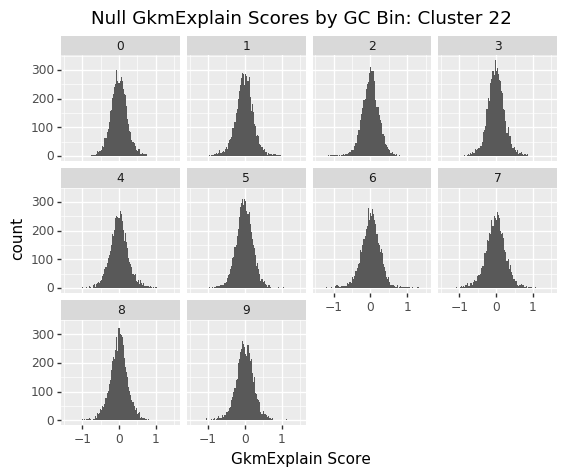

<ggplot: (-9223363300378637466)>

In [13]:
display(ggplot(data=null_scores, mapping=aes(x='null_explain_score'))
        + geom_histogram(bins=100)
        + labs(title='Null GkmExplain Scores by GC Bin: Cluster ' + cluster, x='GkmExplain Score')
        + facet_wrap("gc_bin"))

# Fit Distribution to Null GkmExplain Scores

Fitted t Distribution: 

Mean: 	 -0.0016287404016935045
Stdev: 	 0.2088245236053029

KstestResult(statistic=0.002819880978781719, pvalue=0.7970573878463078)



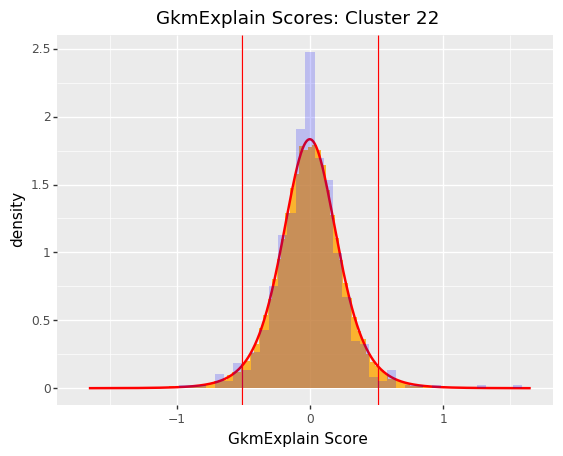

<ggplot: (-9223363300427566511)>

In [14]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
explain_params = distrib.fit(merged_null_explain_scores)
x_explain = np.linspace(distrib.ppf(0.0001, *explain_params[:-2], explain_params[-2], explain_params[-1]),
                        distrib.ppf(0.9999, *explain_params[:-2], explain_params[-2], explain_params[-1]), 10000)
y_explain = distrib.pdf(x_explain, *explain_params[:-2], explain_params[-2], explain_params[-1])
distrib_explain = pd.DataFrame(list(zip(x_explain, y_explain)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', explain_params[-2])
print('Stdev:', '\t', explain_params[-1])
print()
print(kstest(merged_null_explain_scores, distrib_name, args=[*explain_params[:-2], explain_params[-2], explain_params[-1]]))
print()

display(ggplot(data=null_scores, mapping=aes(x='null_explain_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='GkmExplain Scores: Cluster ' + cluster, x='GkmExplain Score')
        + geom_line(data=distrib_explain, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *explain_params[:-2], explain_params[-2], explain_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *explain_params[:-2], explain_params[-2], explain_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='explain_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null ISM Score Distribution by GC Bin

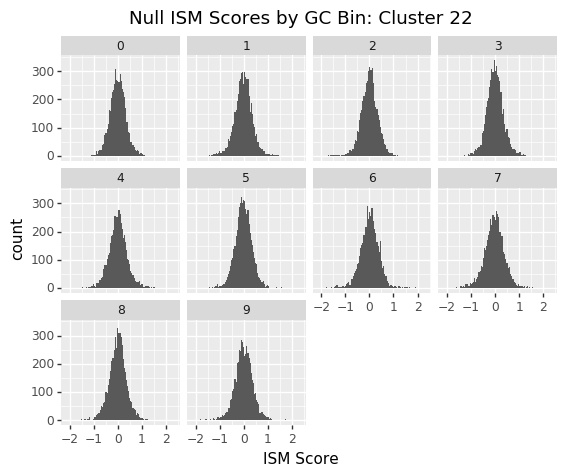

<ggplot: (-9223363300418850900)>

In [15]:
display(ggplot(data=null_scores, mapping=aes(x='null_ism_score'))
        + geom_histogram(bins=100)
        + labs(title='Null ISM Scores by GC Bin: Cluster ' + cluster, x='ISM Score')
        + facet_wrap("gc_bin"))

# Fit Distribution to Null ISM Scores

Fitted t Distribution: 

Mean: 	 -0.002482390180439305
Stdev: 	 0.3110267354948312

KstestResult(statistic=0.0029461318820055427, pvalue=0.7512354444766463)



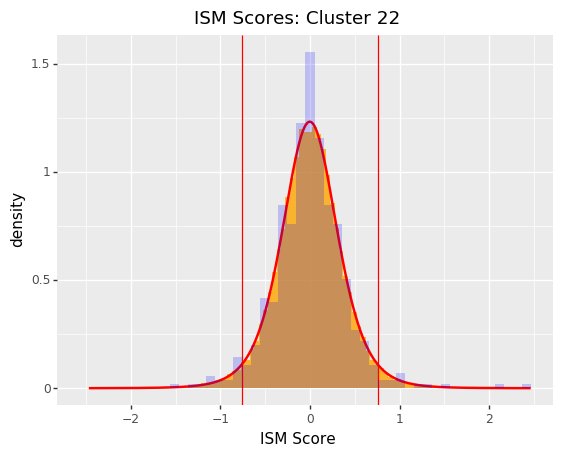

<ggplot: (-9223363300427881093)>

In [16]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
ism_params = distrib.fit(merged_null_ism_scores)
x_ism = np.linspace(distrib.ppf(0.0001, *ism_params[:-2], ism_params[-2], ism_params[-1]),
                        distrib.ppf(0.9999, *ism_params[:-2], ism_params[-2], ism_params[-1]), 10000)
y_ism = distrib.pdf(x_ism, *ism_params[:-2], ism_params[-2], ism_params[-1])
distrib_ism = pd.DataFrame(list(zip(x_ism, y_ism)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', ism_params[-2])
print('Stdev:', '\t', ism_params[-1])
print()
print(kstest(merged_null_ism_scores, distrib_name, args=[*ism_params[:-2], ism_params[-2], ism_params[-1]]))
print()

display(ggplot(data=null_scores, mapping=aes(x='null_ism_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='ISM Scores: Cluster ' + cluster, x='ISM Score')
        + geom_line(data=distrib_ism, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *ism_params[:-2], ism_params[-2], ism_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *ism_params[:-2], ism_params[-2], ism_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='ism_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null deltaSVM Score Distribution by GC Bin

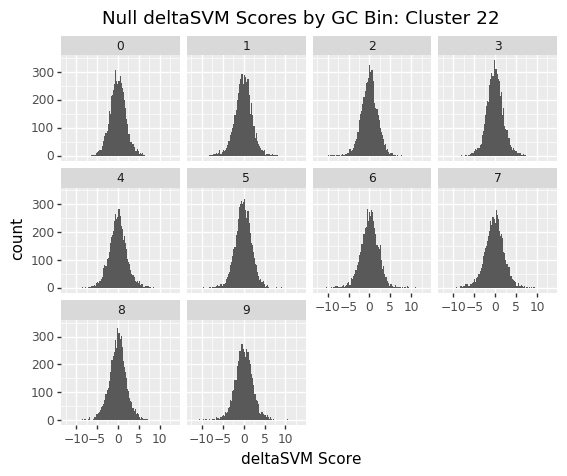

<ggplot: (-9223363300427817212)>

In [17]:
display(ggplot(data=null_scores, mapping=aes(x='null_delta_score'))
        + geom_histogram(bins=100)
        + labs(title='Null deltaSVM Scores by GC Bin: Cluster ' + cluster, x='deltaSVM Score')
        + facet_wrap("gc_bin"))

# Fit Distribution to Null deltaSVM Scores

Fitted t Distribution: 

Mean: 	 -0.013952288684568744
Stdev: 	 1.7973652222099568

KstestResult(statistic=0.0029370646011118717, pvalue=0.7546025674064508)



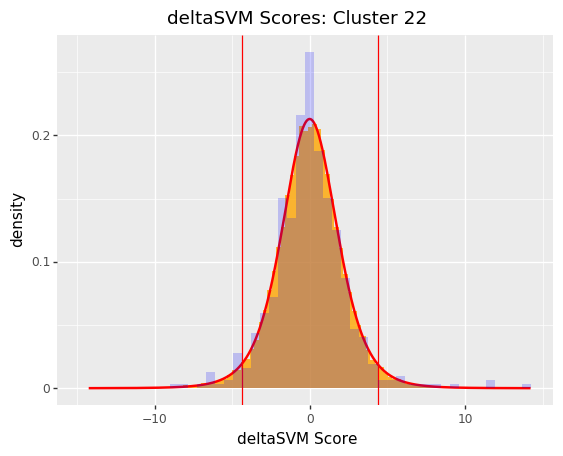

<ggplot: (-9223363300428236421)>

In [18]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
delta_params = distrib.fit(merged_null_delta_scores)
x_delta = np.linspace(distrib.ppf(0.0001, *delta_params[:-2], delta_params[-2], delta_params[-1]),
                        distrib.ppf(0.9999, *delta_params[:-2], delta_params[-2], delta_params[-1]), 10000)
y_delta = distrib.pdf(x_delta, *delta_params[:-2], delta_params[-2], delta_params[-1])
distrib_delta = pd.DataFrame(list(zip(x_delta, y_delta)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', delta_params[-2])
print('Stdev:', '\t', delta_params[-1])
print()
print(kstest(merged_null_delta_scores, distrib_name, args=[*delta_params[:-2], delta_params[-2], delta_params[-1]]))
print()

display(ggplot(data=null_scores, mapping=aes(x='null_delta_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='deltaSVM Scores: Cluster ' + cluster, x='deltaSVM Score')
        + geom_line(data=distrib_delta, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *delta_params[:-2], delta_params[-2], delta_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *delta_params[:-2], delta_params[-2], delta_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='delta_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null Magnitude Score Distribution by GC Bin

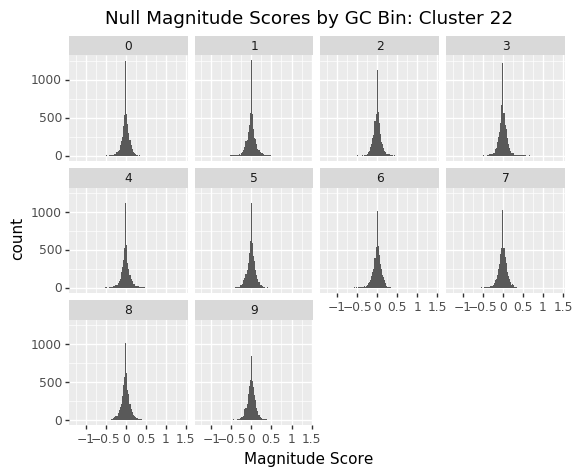

<ggplot: (-9223363300428264041)>

In [19]:
display(ggplot(data=null_scores, mapping=aes(x='null_magnitude_score'))
        + geom_histogram(bins=100)
        + labs(title='Null Magnitude Scores by GC Bin: Cluster ' + cluster, x='Magnitude Score')
        + facet_wrap("gc_bin"))

# Plot All Null Magnitude Scores

Fitted t Distribution: 

Mean: 	 -0.000832454145601638
Stdev: 	 0.066124004628281

KstestResult(statistic=0.03420923315981328, pvalue=6.822093369302544e-54)



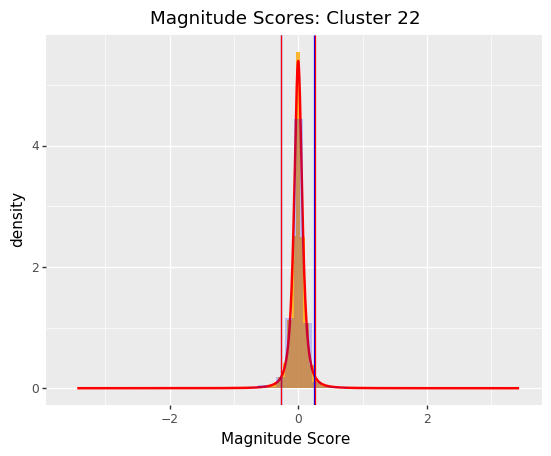

<ggplot: (8736426137983)>

In [20]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
magnitude_params = distrib.fit(null_confidence_dict['null_magnitude_score'])
x_magnitude = np.linspace(distrib.ppf(0.0001, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1]),
                        distrib.ppf(0.9999, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1]), 10000)
y_magnitude = distrib.pdf(x_magnitude, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1])
distrib_magnitude = pd.DataFrame(list(zip(x_magnitude, y_magnitude)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', magnitude_params[-2])
print('Stdev:', '\t', magnitude_params[-1])
print()
print(kstest(null_confidence_dict['null_magnitude_score'], distrib_name, args=[*magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1]]))
print()

null_magnitude_quantiles = list(null_scores['null_magnitude_score'].quantile([0.025, 0.975]))
display(ggplot(data=null_scores, mapping=aes(x='null_magnitude_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='Magnitude Scores: Cluster ' + cluster, x='Magnitude Score')
        + geom_line(data=distrib_magnitude, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=null_magnitude_quantiles[0]), color='blue')
        + geom_vline(mapping=aes(xintercept=null_magnitude_quantiles[1]), color='blue')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *magnitude_params[:-2], magnitude_params[-2], magnitude_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='magnitude_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null Prominence Score Distribution by GC Bin

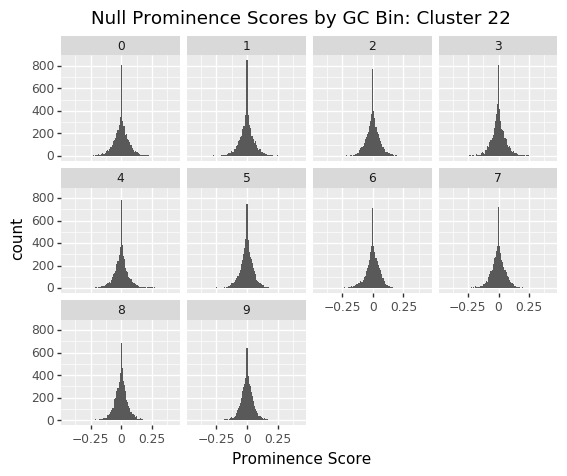

<ggplot: (8736427224019)>

In [21]:
display(ggplot(data=null_scores, mapping=aes(x='null_prominence_score'))
        + geom_histogram(bins=100)
        + labs(title='Null Prominence Scores by GC Bin: Cluster ' + cluster, x='Prominence Score')
        + facet_wrap("gc_bin"))

# Plot All Null Prominence Scores

Fitted t Distribution: 

Mean: 	 -0.0005120726148141765
Stdev: 	 0.0401222281663212

KstestResult(statistic=0.0320441788477861, pvalue=2.4404778947699465e-47)



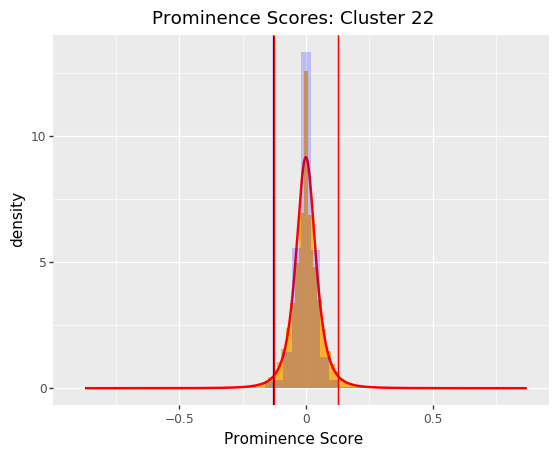

<ggplot: (8736425702250)>

In [22]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
prominence_params = distrib.fit(null_confidence_dict['null_prominence_score'])
x_prominence = np.linspace(distrib.ppf(0.0001, *prominence_params[:-2], prominence_params[-2], prominence_params[-1]),
                        distrib.ppf(0.9999, *prominence_params[:-2], prominence_params[-2], prominence_params[-1]), 10000)
y_prominence = distrib.pdf(x_prominence, *prominence_params[:-2], prominence_params[-2], prominence_params[-1])
distrib_prominence = pd.DataFrame(list(zip(x_prominence, y_prominence)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', prominence_params[-2])
print('Stdev:', '\t', prominence_params[-1])
print()
print(kstest(null_confidence_dict['null_prominence_score'], distrib_name, args=[*prominence_params[:-2], prominence_params[-2], prominence_params[-1]]))
print()
null_prominence_quantiles = list(null_scores['null_prominence_score'].quantile([0.025, 0.975]))

display(ggplot(data=null_scores, mapping=aes(x='null_prominence_score'))
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='Prominence Scores: Cluster ' + cluster, x='Prominence Score')
        + geom_line(data=distrib_prominence, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=null_prominence_quantiles[0]), color='blue')
        + geom_vline(mapping=aes(xintercept=null_prominence_quantiles[1]), color='blue')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *prominence_params[:-2], prominence_params[-2], prominence_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *prominence_params[:-2], prominence_params[-2], prominence_params[-1])), color='red')
        + geom_histogram(data=snp_scores, mapping=aes(x='prominence_score', y='stat(density)'), fill='#0000ff', alpha=0.2, bins=50))

# Plot Null Importance Scores

Fitted t Distribution: 

Mean: 	 0.0041075055943429325
Stdev: 	 0.010534674695227664



KstestResult(statistic=0.01729571618562084, pvalue=2.9496148777628222e-260)



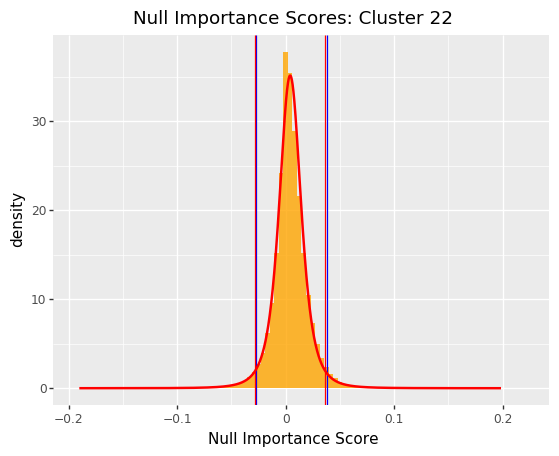

<ggplot: (8736425779853)>

In [23]:
distrib_name = 't'
distrib = getattr(scipy.stats, distrib_name)
sampled_null_importance_scores = random.sample(null_importance_scores, 1000000)
null_importance_df = pd.DataFrame(sampled_null_importance_scores, columns=['null_importance_score'])
importance_params = distrib.fit(sampled_null_importance_scores)
x_importance = np.linspace(distrib.ppf(0.0001, *importance_params[:-2], importance_params[-2], importance_params[-1]),
                           distrib.ppf(0.9999, *importance_params[:-2], importance_params[-2], importance_params[-1]), 10000)
y_importance = distrib.pdf(x_importance, *importance_params[:-2], importance_params[-2], importance_params[-1])
distrib_importance = pd.DataFrame(list(zip(x_importance, y_importance)), columns =['x', 'y'])

print('Fitted ' + distrib_name + ' Distribution: ')
print()
print('Mean:', '\t', importance_params[-2])
print('Stdev:', '\t', importance_params[-1])
print()
print(stats.kstest(sampled_null_importance_scores, distrib_name, args=[*importance_params[:-2], importance_params[-2], importance_params[-1]]))
print()
null_importance_quantiles = list(null_importance_df['null_importance_score'].quantile([0.025, 0.975]))

display(ggplot(data=null_importance_df, mapping=aes(x='null_importance_score'))       
        + geom_histogram(mapping=aes(y='stat(density)'), fill='#ffa500', alpha=0.8, bins=100)
        + labs(title='Null Importance Scores: Cluster ' + cluster, x='Null Importance Score')
        + geom_vline(mapping=aes(xintercept=null_importance_quantiles[0]), color='blue')
        + geom_vline(mapping=aes(xintercept=null_importance_quantiles[1]), color='blue')
        + geom_line(data=distrib_importance, mapping=aes(x='x', y='y'), color='red', size=1)
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.025, *importance_params[:-2], importance_params[-2], importance_params[-1])), color='red')
        + geom_vline(mapping=aes(xintercept=distrib.ppf(0.975, *importance_params[:-2], importance_params[-2], importance_params[-1])), color='red'))

# Get P-Values for SNP Scores <a name='calculate_pvals' />

In [24]:
snp_scores['explain_pval'] = [(2 * min(distrib.cdf(x, *explain_params[:-2], explain_params[-2], explain_params[-1]),
                                      1 - distrib.cdf(x, *explain_params[:-2], explain_params[-2], explain_params[-1]))) \
                              for x in snp_scores['explain_score']]
snp_scores['ism_pval'] = [(2 * min(distrib.cdf(x, *ism_params[:-2], ism_params[-2], ism_params[-1]),
                                  1 - distrib.cdf(x, *ism_params[:-2], ism_params[-2], ism_params[-1]))) \
                              for x in snp_scores['ism_score']]
snp_scores['delta_pval'] = [(2 * min(distrib.cdf(x, *delta_params[:-2], delta_params[-2], delta_params[-1]),
                                  1 - distrib.cdf(x, *delta_params[:-2], delta_params[-2], delta_params[-1]))) \
                              for x in snp_scores['delta_score']]
snp_scores['magnitude_pval'] = [(2 * min((percentileofscore(list(null_scores['null_magnitude_score']), x) / 100),
                                         (1 - (percentileofscore(list(null_scores['null_magnitude_score']), x) / 100)))) \
                                for x in snp_scores['magnitude_score']]
snp_scores['prominence_pval'] = [(2 * min((percentileofscore(list(null_scores['null_prominence_score']), x) / 100),
                                          (1 - (percentileofscore(list(null_scores['null_prominence_score']), x) / 100)))) \
                                 for x in snp_scores['prominence_score']]

confidence_values = []

for index, row in snp_scores.iterrows():
    confidence = -1
    if row['explain_pval'] < 0.05 and row['ism_pval'] < 0.05 and row['delta_pval'] < 0.5:
        confidence += 1
        if row['prominence_pval'] < 0.05:
            confidence += 2
        elif row['magnitude_pval'] < 0.05 or row['prominence_pval'] < 0.10:
            confidence += 1
    confidence_values.append(confidence)

snp_scores['confidence'] = confidence_values
snp_scores.sort_values(by=['prominence_pval', 'magnitude_pval', 'explain_pval'], inplace=True)
snp_scores.sort_values(by=['confidence'], ascending=False, inplace=True)
snp_scores.to_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_snp_scores/Cluster'
                       + cluster + '.' + celltype + '.updated.snp_scores.tsv', sep='\t', index=False)

sig_snps = snp_scores.loc[snp_scores['confidence'] >= 0].copy()
sig_snps = sig_snps.loc[sig_snps['effect'] != 'NA']
sig_snps = sig_snps.loc[sig_snps['noneffect'] != 'NA']
unique_sig_snps = sig_snps.sort_values(by=['rsid','prominence_pval'])
unique_sig_snps.drop_duplicates(subset=['rsid'], inplace=True)
unique_sig_snps.sort_values(by=['prominence_pval', 'magnitude_pval', 'explain_pval'], inplace=True)
unique_sig_snps.sort_values(by=['confidence'], ascending=False, inplace=True)

print('Unique Significant SNPs:')
print()
display(unique_sig_snps)
print()
print('Shape: ', unique_sig_snps.shape)
print()
print('SNPs with Significant Scores:', '\t', '\t', '\t', len(unique_sig_snps))
print('Significant SNPs with Low Confidence:', '\t', '\t', len(unique_sig_snps.loc[unique_sig_snps['confidence'] == 0]))
print('Significant SNPs with Moderate Confidence:', '\t', len(unique_sig_snps.loc[unique_sig_snps['confidence'] == 1]))
print('Significant SNPs with High Confidence:', '\t', '\t', len(unique_sig_snps.loc[unique_sig_snps['confidence'] == 2]))
print()
print('Total SNPs Scored: ', '\t', '\t', '\t', '\t', len(snp_scores))
print('Unique SNPs Scored: ', '\t', '\t', '\t', '\t', len(snp_scores.sort_values(by='rsid').drop_duplicates(subset='rsid')))

Unique Significant SNPs:



,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,gc,explain_score,ism_score,delta_score,magnitude_score,prominence_score,gc_bin,gwas,gwas_pval,coloc,active_seqlet,inactive_seqlet,diff_seqlet,active_allele,explain_pval,ism_pval,delta_pval,magnitude_pval,prominence_pval,confidence
73,chr15,64453059,64453060,rs143560707,G,C,C,G,C,G,+,43,0.424,1.559100,2.446063,14.078846,0.557177,0.295230,1,Alzheimers_Lambert_2013,3.03e-06,True,CAGCTGTAGT,CACCTGTAGT,CA(G/C)CTGTAGT,effect,0.000279,0.000209,0.000212,0.005361,0.001445,2
286,chr17,46771150,46771151,rs199523,C,A,C,A,A,C,-,54,0.693,0.822883,1.306648,7.522203,0.721042,0.188064,9,23andme_PD_hg38,9.49e-14,True,GCGCCACCTACAG,GAGCCACCTACAG,G(C/A)GCCACCTACAG,effect,0.007357,0.005476,0.005553,0.001559,0.012510,2
421,chr2,127128581,127128582,rs13025717,T,C,C,T,C,T,+,77,0.434,-0.511299,-0.796886,-4.465261,-0.499157,-0.147690,1,Alzheimers_Jansen_2018,9.13e-17,False,GCCCCGCCCA,GCCCTGCCCA,GCCC(C/T)GCCCA,noneffect,0.049903,0.042778,0.047467,0.011673,0.034677,2
107,chr17,4901871,4901872,rs79436576,T,C,C,T,C,T,+,55,0.622,-0.700401,-1.095422,-6.468886,-0.670553,-0.141931,8,Alzheimers_Lambert_2013,4.79e-05,True,GGCCCCGCCCC,GGCCTCGCCCC,GGCC(C/T)CGCCCC,noneffect,0.015191,0.012356,0.011210,0.004449,0.039734,2
304,chr17,78426790,78426791,rs72914885,C,A,A,C,A,C,-,62,0.607,-0.590350,-0.913443,-5.424691,-0.491169,-0.132409,7,Nalls_23andMe,0.0446717,False,GTTCTGGAACTGCCAG,GTTCTGGACCTGCCAG,GTTCTGGA(A/C)CTGCCAG,noneffect,0.029961,0.025947,0.023278,0.012471,0.047833,2
390,chr2,95074354,95074355,rs7585473,T,G,T,G,G,T,-,85,0.571,0.938946,1.465175,8.388974,0.439254,0.197141,6,Nalls_23andMe,0.0367323,False,CATTGTC,CATGGTC,CAT(T/G)GTC,effect,0.003956,0.003157,0.003289,0.012319,0.010304,2
456,chr4,959909,959910,rs4690326,C,A,A,C,C,A,-,102,0.641,0.640842,1.014979,5.932545,0.230634,0.118310,8,23andme_PD_hg38,3.53e-10,True,CCCCAGC,CCCAAGC,CCC(C/A)AGC,effect,0.021397,0.016705,0.015900,0.060837,0.058935,1
46,chr11,86103987,86103988,rs1237999,G,A,G,A,A,G,-,16,0.338,0.559290,0.871594,4.999747,0.372132,0.098599,0,Alzheimers_Jansen_2018,7.14e-16,False,GAGTCACCAAC,AAGTCACCAAC,(G/A)AGTCACCAAC,effect,0.035782,0.030337,0.031128,0.020228,0.093954,1
328,chr19,18462023,18462024,rs8103622,T,C,C,T,C,T,+,69,0.581,-0.654659,-1.076247,-6.166603,-0.625827,-0.072729,6,Alzheimers_Kunkle_2019,1.28e-05,True,AGAGCGCCACCTGCTG,AGAGTGCCACCTGCTG,AGAG(C/T)GCCACCTGCTG,noneffect,0.020049,0.013328,0.013779,0.005894,0.191673,1
518,chr6,27772520,27772521,rs760587,C,A,C,A,C,A,-,110,0.498,-0.527136,-0.829844,-4.709268,-0.523668,-0.124789,3,Nalls_23andMe,6.44e-06,False,CAGCAAACAAAGGC,CAGCAACCAAAGGC,CAGCAA(A/C)CAAAGGC,noneffect,0.044998,0.037075,0.039473,0.010190,0.056844,1



Shape:  (26, 32)

SNPs with Significant Scores: 	 	 	 26
Significant SNPs with Low Confidence: 	 	 14
Significant SNPs with Moderate Confidence: 	 6
Significant SNPs with High Confidence: 	 	 6

Total SNPs Scored:  	 	 	 	 550
Unique SNPs Scored:  	 	 	 	 490


# Visualize High Confidence SNPs <a name='visualize_high_conf' />


Index: 73

RSID: rs143560707 	 	 || 	 chr15 : 64453059 - 64453060 	 || 	 Locus: 43

GWAS: Alzheimers_Lambert_2013 	 || 	 GWAS P-Value: 3.0300E-06 	 || 	 Coloc: True

Prominence P-Value: 1.4449E-03 	 || 	 Magnitude P-Value: 5.3612E-03 	 || 	 Confidence: 2

GkmExplain P-Value: 2.7852E-04 	 || 	 ISM P-Value: 2.0907E-04 	 || 	 deltaSVM P-Value: 2.1193E-04

----------------------------------------------------------------------------------------------------

Effect Allele: G 	 	 || 	 Active Seqlet: CAGCTGTAGT



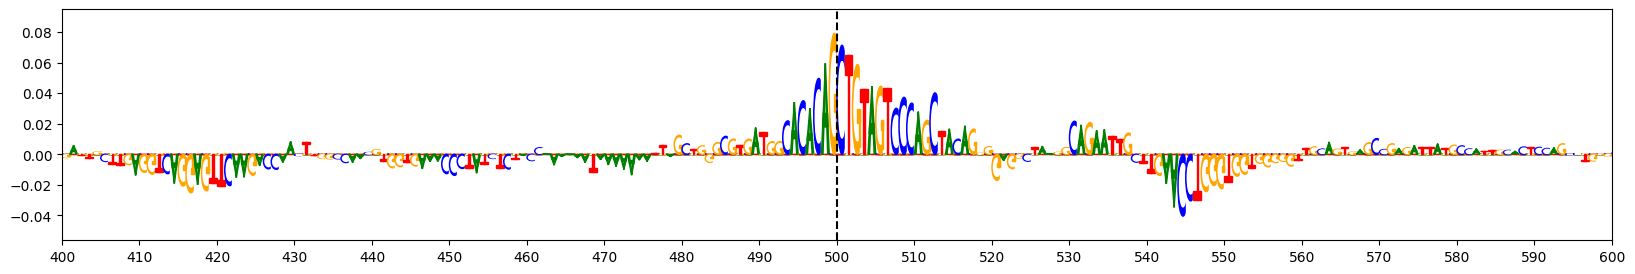


Non-Effect Allele: C 	 	 || 	 Inactive Seqlet: CACCTGTAGT



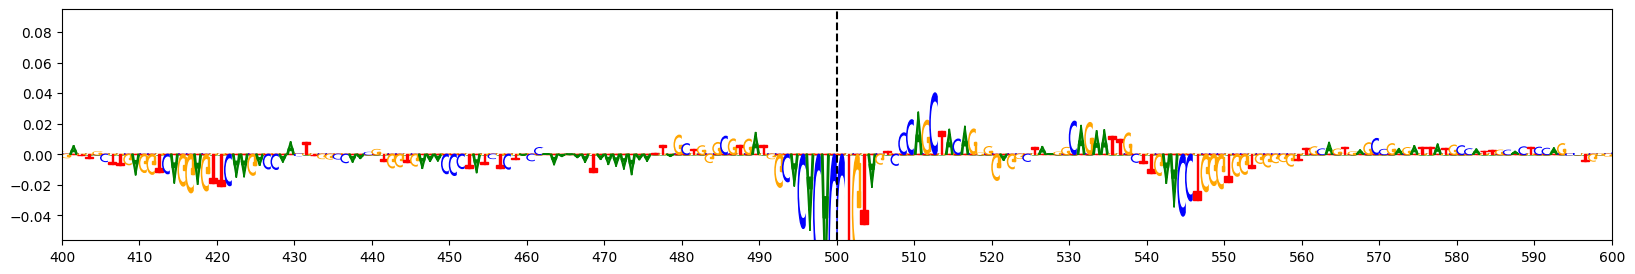


Difference Seqlet: CA(G/C)CTGTAGT



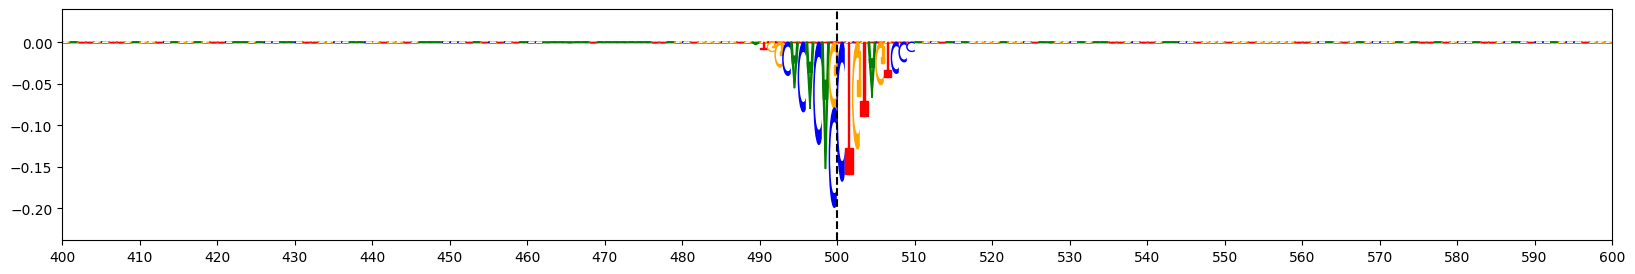


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 286

RSID: rs199523 	 	 || 	 chr17 : 46771150 - 46771151 	 || 	 Locus: 54

GWAS: 23andme_PD_hg38 	 || 	 GWAS P-Value: 9.4900E-14 	 || 	 Coloc: True

Prominence P-Value: 1.2510E-02 	 || 	 Magnitude P-Value: 1.5589E-03 	 || 	 Confidence: 2

GkmExplain P-Value: 7.3571E-03 	 || 	 ISM P-Value: 5.4755E-03 	 || 	 deltaSVM P-Value: 5.5533E-03

----------------------------------------------------------------------------------------------------

Effect Allele: C 	 	 || 	 Active Seqlet: GCGCCACCTACAG



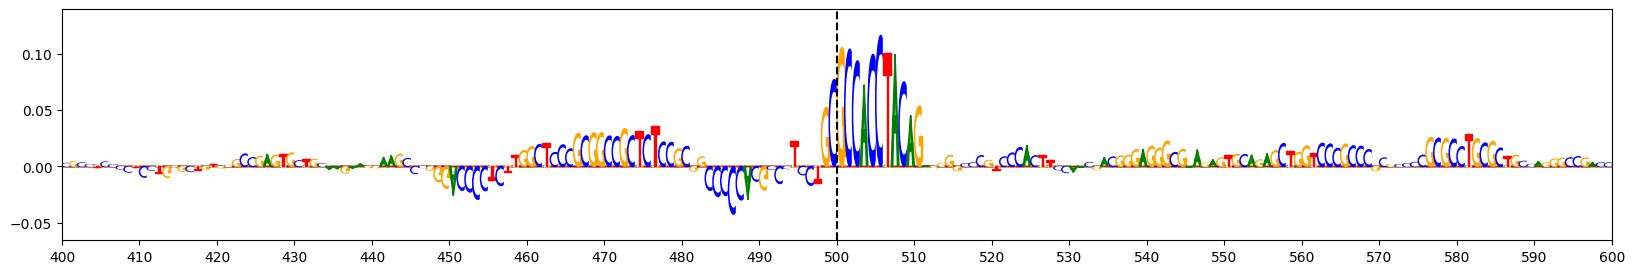


Non-Effect Allele: A 	 	 || 	 Inactive Seqlet: GAGCCACCTACAG



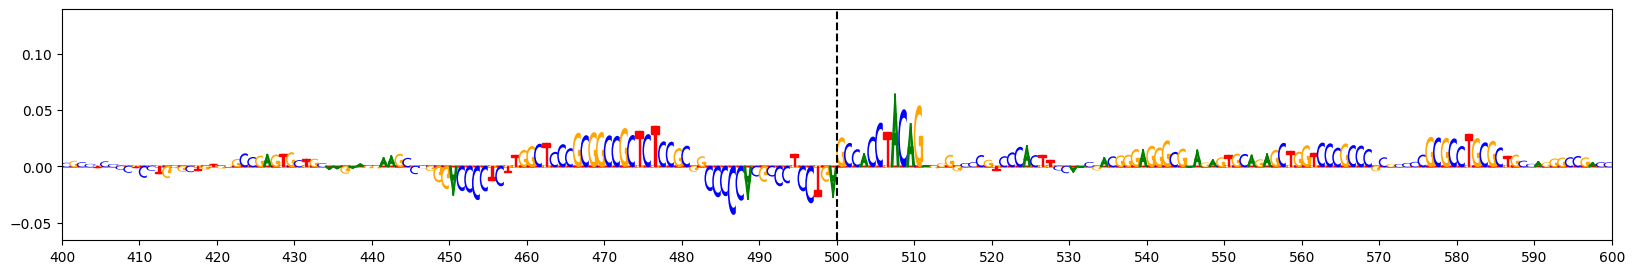


Difference Seqlet: G(C/A)GCCACCTACAG



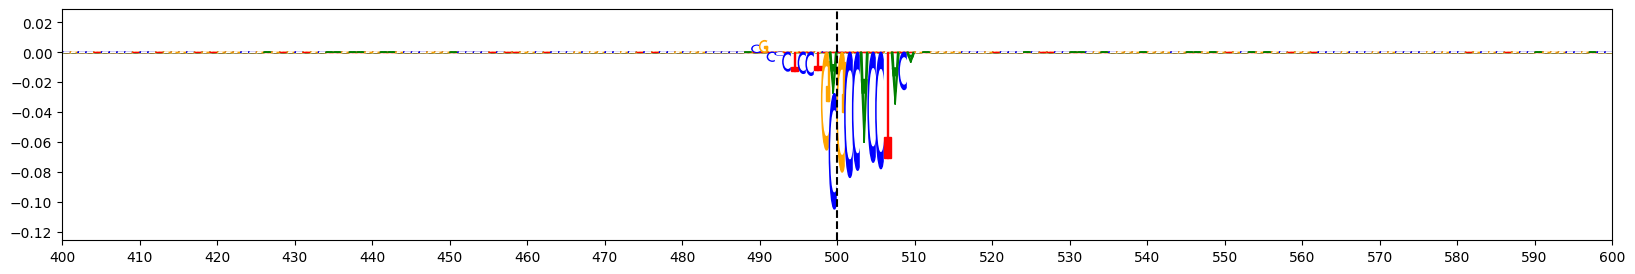


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 421

RSID: rs13025717 	 	 || 	 chr2 : 127128581 - 127128582 	 || 	 Locus: 77

GWAS: Alzheimers_Jansen_2018 	 || 	 GWAS P-Value: 9.1300E-17 	 || 	 Coloc: False

Prominence P-Value: 3.4677E-02 	 || 	 Magnitude P-Value: 1.1673E-02 	 || 	 Confidence: 2

GkmExplain P-Value: 4.9903E-02 	 || 	 ISM P-Value: 4.2778E-02 	 || 	 deltaSVM P-Value: 4.7467E-02

----------------------------------------------------------------------------------------------------

Non-Effect Allele: C 	 	 || 	 Active Seqlet: GCCCCGCCCA



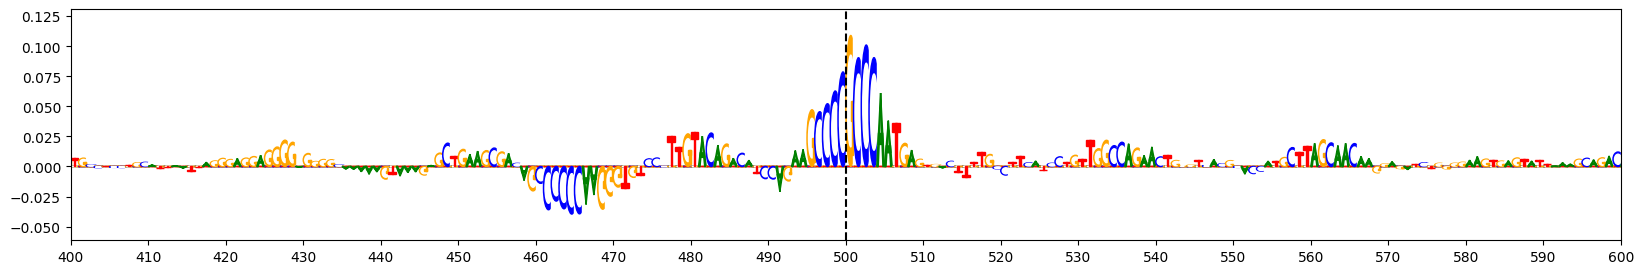


Effect Allele: T 	 	 || 	 Inactive Seqlet: GCCCTGCCCA



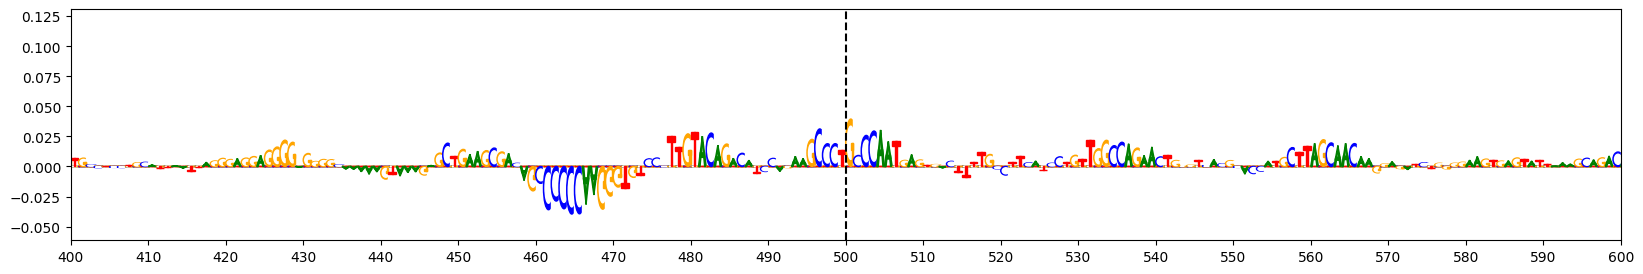


Difference Seqlet: GCCC(C/T)GCCCA



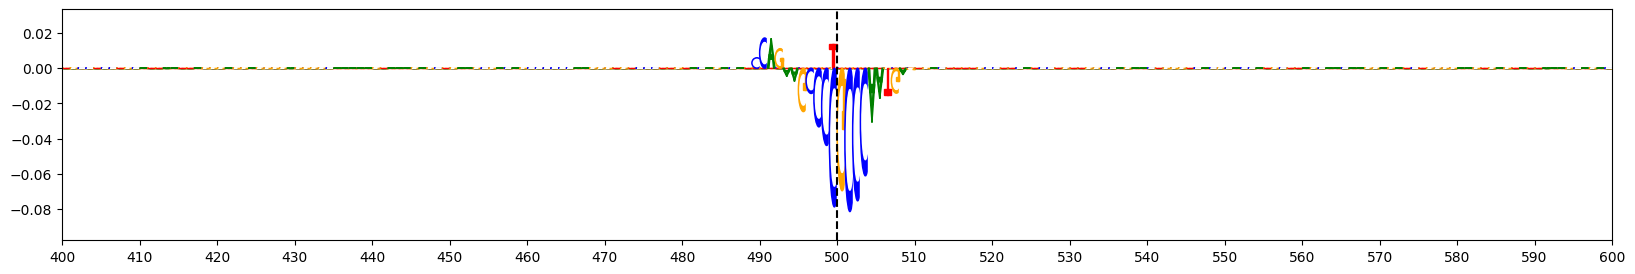


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 107

RSID: rs79436576 	 	 || 	 chr17 : 4901871 - 4901872 	 || 	 Locus: 55

GWAS: Alzheimers_Lambert_2013 	 || 	 GWAS P-Value: 4.7900E-05 	 || 	 Coloc: True

Prominence P-Value: 3.9734E-02 	 || 	 Magnitude P-Value: 4.4487E-03 	 || 	 Confidence: 2

GkmExplain P-Value: 1.5191E-02 	 || 	 ISM P-Value: 1.2356E-02 	 || 	 deltaSVM P-Value: 1.1210E-02

----------------------------------------------------------------------------------------------------

Non-Effect Allele: C 	 	 || 	 Active Seqlet: GGCCCCGCCCC



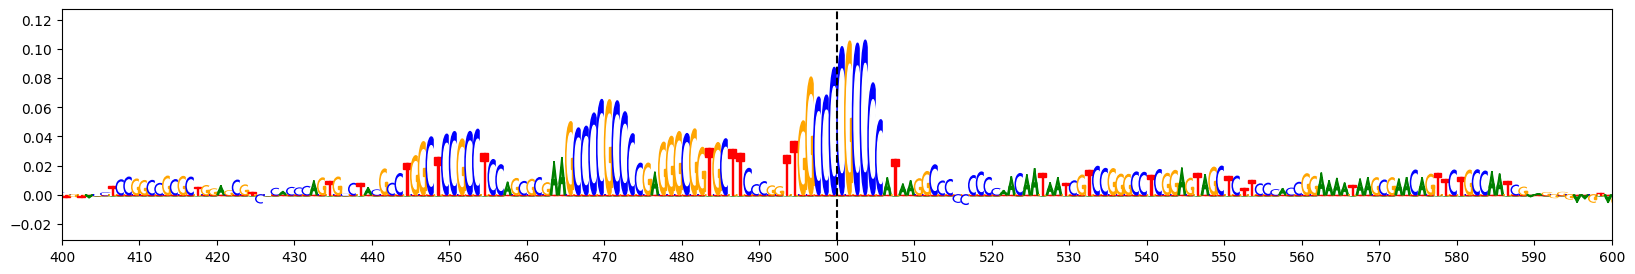


Effect Allele: T 	 	 || 	 Inactive Seqlet: GGCCTCGCCCC



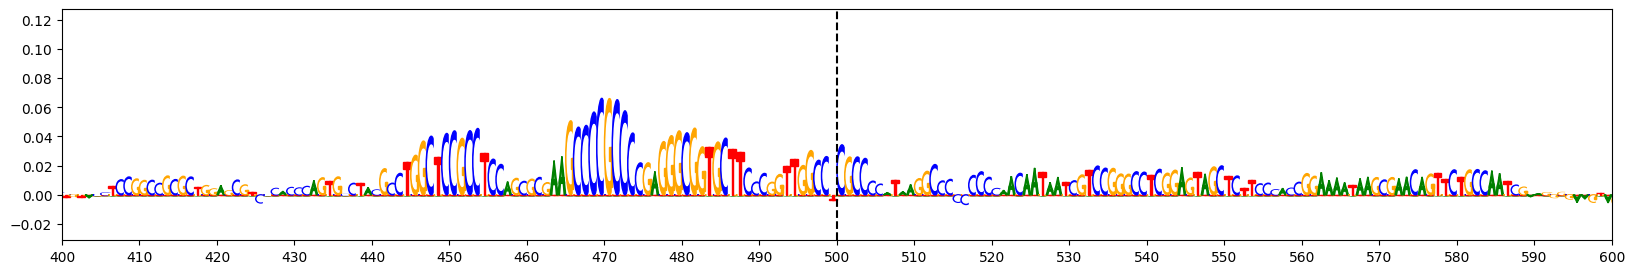


Difference Seqlet: GGCC(C/T)CGCCCC



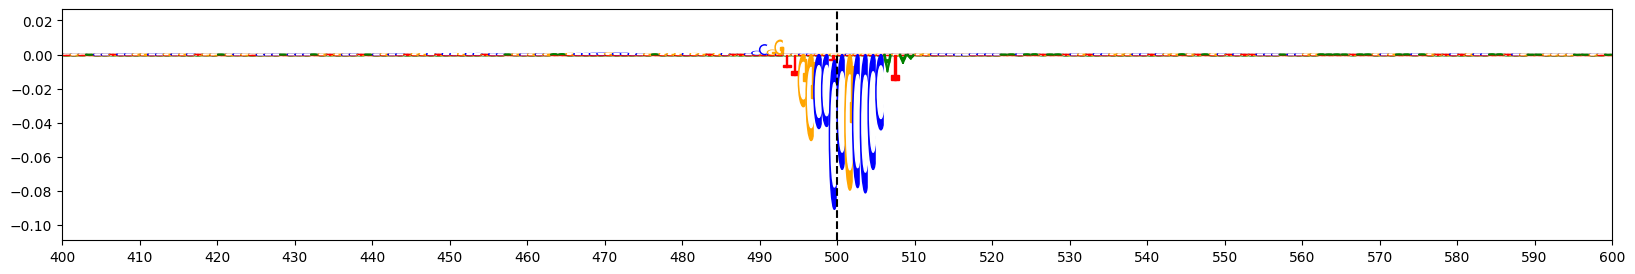


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 304

RSID: rs72914885 	 	 || 	 chr17 : 78426790 - 78426791 	 || 	 Locus: 62

GWAS: Nalls_23andMe 	 || 	 GWAS P-Value: 4.4672E-02 	 || 	 Coloc: False

Prominence P-Value: 4.7833E-02 	 || 	 Magnitude P-Value: 1.2471E-02 	 || 	 Confidence: 2

GkmExplain P-Value: 2.9961E-02 	 || 	 ISM P-Value: 2.5947E-02 	 || 	 deltaSVM P-Value: 2.3278E-02

----------------------------------------------------------------------------------------------------

Non-Effect Allele: A 	 	 || 	 Active Seqlet: GTTCTGGAACTGCCAG



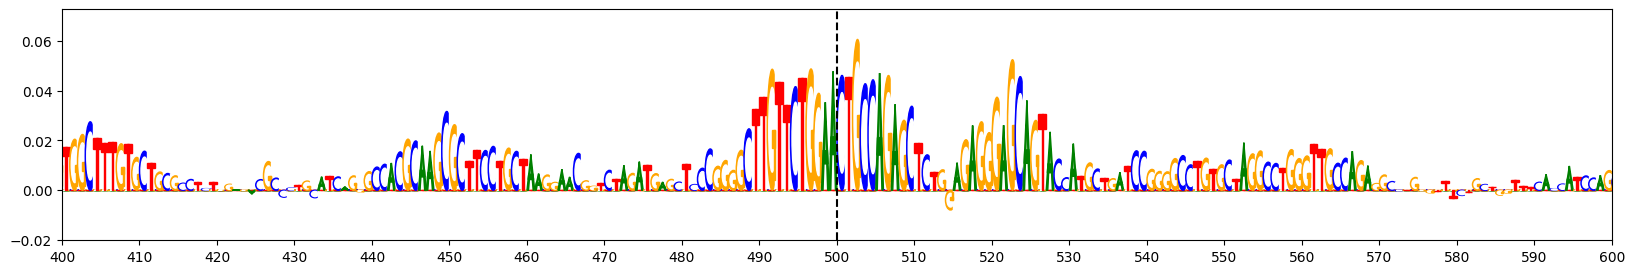


Effect Allele: C 	 	 || 	 Inactive Seqlet: GTTCTGGACCTGCCAG



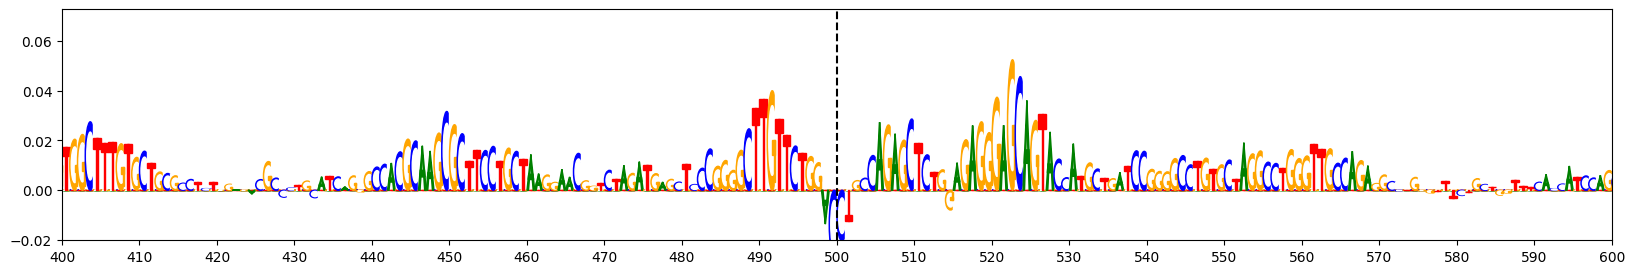


Difference Seqlet: GTTCTGGA(A/C)CTGCCAG



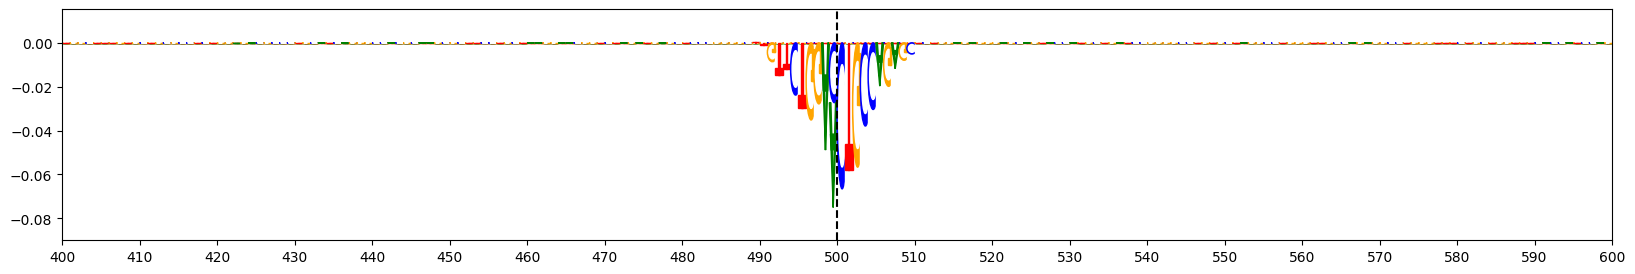


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


Index: 390

RSID: rs7585473 	 	 || 	 chr2 : 95074354 - 95074355 	 || 	 Locus: 85

GWAS: Nalls_23andMe 	 || 	 GWAS P-Value: 3.6732E-02 	 || 	 Coloc: False

Prominence P-Value: 1.0304E-02 	 || 	 Magnitude P-Value: 1.2319E-02 	 || 	 Confidence: 2

GkmExplain P-Value: 3.9563E-03 	 || 	 ISM P-Value: 3.1566E-03 	 || 	 deltaSVM P-Value: 3.2885E-03

----------------------------------------------------------------------------------------------------

Effect Allele: T 	 	 || 	 Active Seqlet: CATTGTC



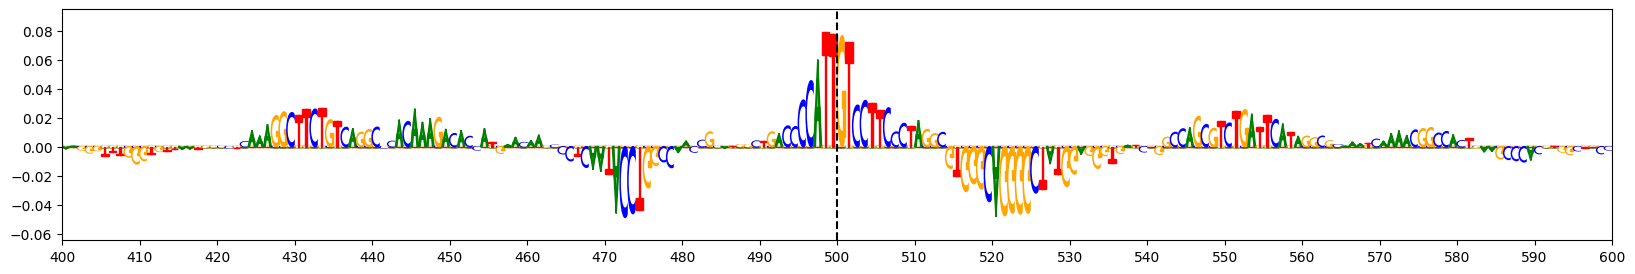


Non-Effect Allele: G 	 	 || 	 Inactive Seqlet: CATGGTC



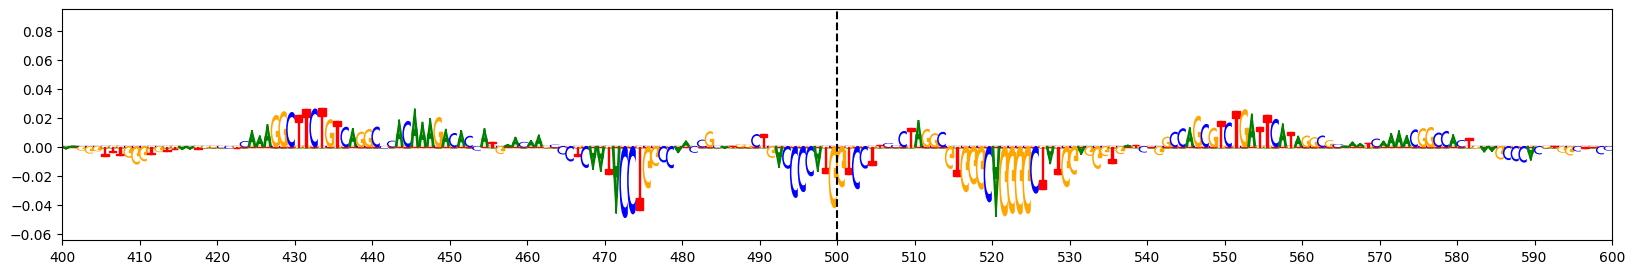


Difference Seqlet: CAT(T/G)GTC



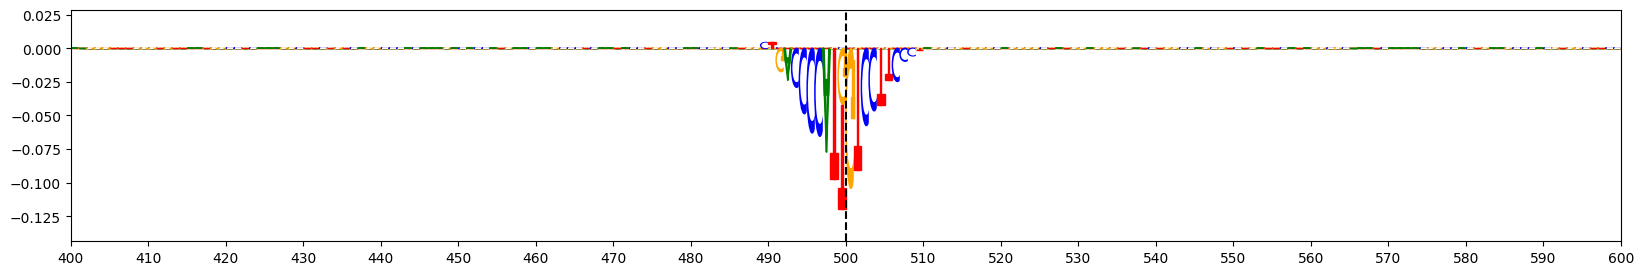


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



In [25]:
for index,row in unique_sig_snps.loc[unique_sig_snps['confidence'] == 2].iterrows():
    print()
    print('Index:', index)
    print()
    print('RSID:', row['rsid'],
          '\t', '\t', '||', '\t',
          row['chr'], ':', row['start'], '-', row['end'],
          '\t', '||', '\t',
          'Locus:', row['locus_num'])
    print()
    print('GWAS:', row['gwas'],
          '\t', '||', '\t',
          'GWAS P-Value:', '%.4E' % Decimal(row['gwas_pval']),
          '\t', '||', '\t',
          'Coloc:', row['coloc'])
    print()
    print('Prominence P-Value:', '%.4E' % Decimal(row['prominence_pval']),
          '\t', '||', '\t',
          'Magnitude P-Value:', '%.4E' % Decimal(row['magnitude_pval']),
          '\t', '||', '\t',
          'Confidence:', row['confidence'])
    print()
    print('GkmExplain P-Value:', '%.4E' % Decimal(row['explain_pval']),
          '\t', '||', '\t',
          'ISM P-Value:', '%.4E' % Decimal(row['ism_pval']),
          '\t', '||', '\t',
          'deltaSVM P-Value:', '%.4E' % Decimal(row['delta_pval']))    
    print()
    print('-'*100)
    print()
    
    #--------------------------------------#
    
    if row['active_allele'] == 'effect':
        if row['effect'] != 'NA':
            print('Effect Allele:', row['effect'],
                  '\t', '\t', '||', '\t',
                  'Active Seqlet:', row['active_seqlet'])
        else:
            print('Minor Allele:', row['minor'],
                  '\t', '\t', '||', '\t',
                  'Active Seqlet:', row['active_seqlet'])
        print()
        ylim = plot_weights(merged_observed_effect_scores[index],
                            subticks_frequency=10, xlim=(400,600))
        print()
    else:
        if row['noneffect'] != 'NA':
            print('Non-Effect Allele:', row['noneffect'],
                  '\t', '\t', '||', '\t',
                  'Active Seqlet:', row['active_seqlet'])
        else:
            print('Major Allele:', row['major'],
                  '\t', '\t', '||', '\t',
                  'Active Seqlet:', row['active_seqlet'])
        print()
        ylim = plot_weights(merged_observed_noneffect_scores[index],
                            subticks_frequency=10, xlim=(400,600))
        print()
        
    #--------------------------------------#
        
    if row['active_allele'] != 'effect':
        if row['effect'] != 'NA':
            print('Effect Allele:', row['effect'],
                  '\t', '\t', '||', '\t',
                  'Inactive Seqlet:', row['inactive_seqlet'])
        else:
            print('Minor Allele:', row['minor'],
                  '\t', '\t', '||', '\t',
                  'Inactive Seqlet:', row['inactive_seqlet'])
        print()
        a = plot_weights(merged_observed_effect_scores[index],
                         subticks_frequency=10, ylim=ylim, xlim=(400,600))
        print()
    else:
        if row['noneffect'] != 'NA':
            print('Non-Effect Allele:', row['noneffect'],
                  '\t', '\t', '||', '\t',
                  'Inactive Seqlet:', row['inactive_seqlet'])
        else:
            print('Major Allele:', row['major'],
                  '\t', '\t', '||', '\t',
                  'Inactive Seqlet:', row['inactive_seqlet'])
        print()
        a = plot_weights(merged_observed_noneffect_scores[index],
                         subticks_frequency=10, ylim=ylim, xlim=(400,600))
        print()
    
    #--------------------------------------#
    
    print('Difference Seqlet:', row['diff_seqlet'])
    print()
    if row['active_allele'] == 'effect':
        a = plot_weights(merged_observed_noneffect_scores[index] - merged_observed_effect_scores[index],
                         subticks_frequency=10, xlim=(400,600))
    else:
        a = plot_weights(merged_observed_effect_scores[index] - merged_observed_noneffect_scores[index],
                         subticks_frequency=10, xlim=(400,600))
    print()
    print('-'*100)
    print('-'*100)
    print()

## Generate Signal Tracks

In [26]:
fc_tracks = []
pval_tracks = []

for index, row in unique_sig_snps.iterrows():
    chrom = row['chr']
    start = row['start'] - 2500
    end = row['end'] + 2500
    rsid = row['rsid']
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/fc_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_snp_fc_signal_tracks/{rsid}.fc.png
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/pval_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_snp_pval_signal_tracks/{rsid}.pval.png
    fc_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/updated_snp_fc_signal_tracks/'+rsid+'.fc.png')
    pval_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/updated_snp_pval_signal_tracks/'+rsid+'.pval.png')
        
unique_sig_snps['fc_track'] = fc_tracks
unique_sig_snps['pval_track'] = pval_tracks

INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.1602492332458496
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16950392723083496
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.6135292053222656


DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15741419792175293
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15827059745788574
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 789.9999999999999,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.21115994453430176
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 789.9999999999999,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.1555495262145996
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 560.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15856695175170898
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 560.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15749621391296387
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1019.9999999999999,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15233874320983887
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1019.9999999999999,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.26233839988708496
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.1534414291381836
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16229796409606934
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 560.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.17869305610656738
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 560.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.1697547435760498
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.22831988334655762
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15206027030944824
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.2032771110534668
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16012787818908691
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15970087051391602
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15619611740112305
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1019.9999999999999,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.17235803604125977
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1019.9999999999999,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15892720222473145
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.14575910568237305
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.1603691577911377
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.6216905117034912
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.2549600601196289
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 789.9999999999999,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.1707925796508789
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 789.9999999999999,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15551328659057617
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1019.9999999999999,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15864801406860352
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1019.9999999999999,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.1614677906036377
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.15996932983398438
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16028547286987305
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1479.9999999999998,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.17223381996154785
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1479.9999999999998,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16003680229187012
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.20376300811767578
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16387605667114258
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1479.9999999999998,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16301202774047852
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1479.9999999999998,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16127777099609375
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16032075881958008
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16720128059387207
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1249.9999999999998,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16028165817260742
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 1249.9999999999998,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.1646428108215332
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16857433319091797
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.1902306079864502
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16594243049621582
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.1749866008758545
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.20829558372497559
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.17452502250671387
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16350030899047852
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]


INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 330.0,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.16170787811279297
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72



INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]


INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]


INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]


INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]


INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.1707441806793213
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]


INFO:pygenometracks.tracksClass:plotting 2. [spacer]


INFO:pygenometracks.tracksClass:plotting 3. [cluster2]


INFO:pygenometracks.tracksClass:plotting 4. [spacer]


INFO:pygenometracks.tracksClass:plotting 5. [cluster3]


INFO:pygenometracks.tracksClass:plotting 6. [spacer]


INFO:pygenometracks.tracksClass:plotting 7. [cluster4]


INFO:pygenometracks.tracksClass:plotting 8. [spacer]


INFO:pygenometracks.tracksClass:plotting 9. [cluster5]


INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]


INFO:pygenometracks.tracksClass:plotting 12. [spacer]


INFO:pygenometracks.tracksClass:plotting 13. [cluster7]


INFO:pygenometracks.tracksClass:plotting 14. [spacer]


INFO:pygenometracks.tracksClass:plotting 15. [cluster8]


INFO:pygenometracks.tracksClass:plotting 16. [spacer]


INFO:pygenometracks.tracksClass:plotting 17. [cluster9]


INFO:pygenometracks.tracksClass:plotting 18. [spacer]


INFO:pygenometracks.tracksClass:plotting 19. [cluster10]


INFO:pygenometracks.tracksClass:plotting 20. [spacer]


INFO:pygenometracks.tracksClass:plotting 21. [cluster11]


INFO:pygenometracks.tracksClass:plotting 22. [spacer]


INFO:pygenometracks.tracksClass:plotting 23. [cluster12]


INFO:pygenometracks.tracksClass:plotting 24. [spacer]


INFO:pygenometracks.tracksClass:plotting 25. [cluster13]


INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]


INFO:pygenometracks.tracksClass:plotting 28. [spacer]


INFO:pygenometracks.tracksClass:plotting 29. [cluster15]


INFO:pygenometracks.tracksClass:plotting 30. [spacer]


INFO:pygenometracks.tracksClass:plotting 31. [cluster16]


INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]


INFO:pygenometracks.tracksClass:plotting 34. [spacer]


INFO:pygenometracks.tracksClass:plotting 35. [cluster18]


INFO:pygenometracks.tracksClass:plotting 36. [spacer]


INFO:pygenometracks.tracksClass:plotting 37. [cluster19]


INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]


INFO:pygenometracks.tracksClass:plotting 40. [spacer]


INFO:pygenometracks.tracksClass:plotting 41. [cluster21]


INFO:pygenometracks.tracksClass:plotting 42. [spacer]


INFO:pygenometracks.tracksClass:plotting 43. [cluster22]


INFO:pygenometracks.tracksClass:plotting 44. [spacer]


INFO:pygenometracks.tracksClass:plotting 45. [cluster23]


INFO:pygenometracks.tracksClass:plotting 46. [spacer]


INFO:pygenometracks.tracksClass:plotting 47. [cluster24]


INFO:pygenometracks.tracksClass:plotting 48. [spacer]


INFO:pygenometracks.tracksClass:plotting 49. [snps]


DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]


# Final Significant SNPs Table <a name='prep_final_table' />

In [27]:
final_sig_snps = unique_sig_snps[['chr', 'start', 'end', 'rsid',
                                  'effect', 'noneffect', 'major', 'minor', 'direction',
                                  'locus_num', 'gwas', 'gwas_pval', 'coloc',
                                  'explain_pval', 'ism_pval', 'delta_pval',
                                  'magnitude_pval', 'prominence_pval', 'confidence',
                                  'active_seqlet', 'diff_seqlet', 'active_allele',
                                  'fc_track', 'pval_track']]

final_sig_snps.to_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/updated_sig_snps/Cluster'
                       + cluster + '.' + celltype + '.updated.unique.sig_snps.tsv', sep='\t', index=False)
print('Final Significant SNPs Table:')
print()
display(final_sig_snps)
print()
print('Shape: ', final_sig_snps.shape)

Final Significant SNPs Table:



,chr,start,end,rsid,effect,noneffect,major,minor,direction,locus_num,gwas,gwas_pval,coloc,explain_pval,ism_pval,delta_pval,magnitude_pval,prominence_pval,confidence,active_seqlet,diff_seqlet,active_allele,fc_track,pval_track
73,chr15,64453059,64453060,rs143560707,G,C,C,G,+,43,Alzheimers_Lambert_2013,3.03e-06,True,0.000279,0.000209,0.000212,0.005361,0.001445,2,CAGCTGTAGT,CA(G/C)CTGTAGT,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
286,chr17,46771150,46771151,rs199523,C,A,A,C,-,54,23andme_PD_hg38,9.49e-14,True,0.007357,0.005476,0.005553,0.001559,0.012510,2,GCGCCACCTACAG,G(C/A)GCCACCTACAG,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
421,chr2,127128581,127128582,rs13025717,T,C,C,T,+,77,Alzheimers_Jansen_2018,9.13e-17,False,0.049903,0.042778,0.047467,0.011673,0.034677,2,GCCCCGCCCA,GCCC(C/T)GCCCA,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
107,chr17,4901871,4901872,rs79436576,T,C,C,T,+,55,Alzheimers_Lambert_2013,4.79e-05,True,0.015191,0.012356,0.011210,0.004449,0.039734,2,GGCCCCGCCCC,GGCC(C/T)CGCCCC,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
304,chr17,78426790,78426791,rs72914885,C,A,A,C,-,62,Nalls_23andMe,0.0446717,False,0.029961,0.025947,0.023278,0.012471,0.047833,2,GTTCTGGAACTGCCAG,GTTCTGGA(A/C)CTGCCAG,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
390,chr2,95074354,95074355,rs7585473,T,G,G,T,-,85,Nalls_23andMe,0.0367323,False,0.003956,0.003157,0.003289,0.012319,0.010304,2,CATTGTC,CAT(T/G)GTC,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
456,chr4,959909,959910,rs4690326,C,A,C,A,-,102,23andme_PD_hg38,3.53e-10,True,0.021397,0.016705,0.015900,0.060837,0.058935,1,CCCCAGC,CCC(C/A)AGC,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
46,chr11,86103987,86103988,rs1237999,G,A,A,G,-,16,Alzheimers_Jansen_2018,7.14e-16,False,0.035782,0.030337,0.031128,0.020228,0.093954,1,GAGTCACCAAC,(G/A)AGTCACCAAC,effect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
328,chr19,18462023,18462024,rs8103622,T,C,C,T,+,69,Alzheimers_Kunkle_2019,1.28e-05,True,0.020049,0.013328,0.013779,0.005894,0.191673,1,AGAGCGCCACCTGCTG,AGAG(C/T)GCCACCTGCTG,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...
518,chr6,27772520,27772521,rs760587,C,A,C,A,-,110,Nalls_23andMe,6.44e-06,False,0.044998,0.037075,0.039473,0.010190,0.056844,1,CAGCAAACAAAGGC,CAGCAA(A/C)CAAAGGC,noneffect,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...



Shape:  (26, 24)
